# Project Stage 3

In [831]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statistics
from statistics import mean, median, variance
from scipy import stats

**Reading from parquet**

In [832]:
us_data = pd.read_parquet("../../../data/covid_combined_dataset.parquet.gzip")

In [833]:
us_data.columns

Index(['countyFIPS', 'County Name', 'State', 'StateFIPS', 'Date', 'Cases',
       'Death', 'population'],
      dtype='object')

### Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties (top 5 with highest number of cases). Start your data from the first day of infections.

In [834]:
# North Carolina State

nc_data = us_data[us_data['State']=='NC']
nc_data.head()

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
1432620,37001,Alamance County,NC,37,2020-01-22,0,0,169509
1432621,37001,Alamance County,NC,37,2020-01-23,0,0,169509
1432622,37001,Alamance County,NC,37,2020-01-24,0,0,169509
1432623,37001,Alamance County,NC,37,2020-01-25,0,0,169509
1432624,37001,Alamance County,NC,37,2020-01-26,0,0,169509


In [835]:
nc_data.shape

(75800, 8)

In [836]:
nc_data_1 = nc_data.groupby('Date')[['Cases','Death']].sum()
nc_data_1 = nc_data_1.reset_index()
nc_data_1.head()

,Date,Cases,Death
0,2020-01-22,0,0
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0


### To find the start day of the infections

In [837]:
# https://stackoverflow.com/a/2236935
next(x[0] for x in enumerate(list(nc_data_1['Cases'].values)) if x[1] > 0)


41

In [838]:
nc_data_1[35:45]

,Date,Cases,Death
35,2020-02-26,0,0
36,2020-02-27,0,0
37,2020-02-28,0,0
38,2020-02-29,0,0
39,2020-03-01,0,0
40,2020-03-02,0,0
41,2020-03-03,1,0
42,2020-03-04,1,0
43,2020-03-05,1,0
44,2020-03-06,2,0


In [839]:
nc_data_1 = nc_data_1[41:]

In [840]:
nc_data_1['new_cases'] = nc_data_1['Cases'].diff()
nc_data_1['new_deaths'] = nc_data_1['Death'].diff()

In [841]:
nc_data_1 = nc_data_1[1:]
nc_data_1.head()

,Date,Cases,Death,new_cases,new_deaths
42,2020-03-04,1,0,0.0,0.0
43,2020-03-05,1,0,0.0,0.0
44,2020-03-06,2,0,1.0,0.0
45,2020-03-07,2,0,0.0,0.0
46,2020-03-08,2,0,0.0,0.0


In [842]:
# Removing the negative values
def non_neg_values(x):
    if x <=0:
        return 0
    else:
        return x


In [843]:
nc_data_1['new_cases'] = nc_data_1['new_cases'].apply(non_neg_values)
''

''

In [844]:
nc_data_1['new_deaths'] = nc_data_1['new_deaths'].apply(non_neg_values)


In [845]:
min(nc_data_1['new_deaths'])

0.0

In [846]:
nc_data_1.shape

(716, 5)

## Plotting North Carolina New Cases

In [822]:
# https://plotly.com/python/line-charts/
fig = px.line(nc_data_1, x="Date", y="new_cases", title='North Carolina New Cases plot')
fig.show()

## Plotting North Carolina New Deaths

In [823]:
# https://plotly.com/python/line-charts/
fig = px.line(nc_data_1, x="Date", y="new_deaths", title='North Carolina New Deaths plot')
fig.show()

### Inserting Day counts as a feature

In [847]:
nc_data_1['Day_count'] = np.arange(42,len(nc_data_1)+42)
nc_data_1

,Date,Cases,Death,new_cases,new_deaths,Day_count
42,2020-03-04,1,0,0.0,0.0,42
43,2020-03-05,1,0,0.0,0.0,43
44,2020-03-06,2,0,1.0,0.0,44
45,2020-03-07,2,0,0.0,0.0,45
46,2020-03-08,2,0,0.0,0.0,46
...,...,...,...,...,...,...
753,2022-02-13,2524539,21665,0.0,0.0,753
754,2022-02-14,2539564,21781,15025.0,116.0,754
755,2022-02-15,2542484,21835,2920.0,54.0,755
756,2022-02-16,2548568,21968,6084.0,133.0,756


### Training and Test data seperation

**We consider the first 696 days as the train data and we will consider the remaining 20 days as test data and predict the cases for the remaining 20 days.**

In [848]:
X_train = nc_data_1['Day_count'][:696]
y_train_c = nc_data_1['new_cases'][:696]
y_train_d = nc_data_1['new_deaths'][:696]
X_test = nc_data_1['Day_count'][696:]
y_test_c = nc_data_1['new_cases'][696:]
y_test_d = nc_data_1['new_deaths'][696:]

In [849]:
X_train = np.array(X_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)

## Linear Regression for new cases

In [850]:
lr = LinearRegression()
lr.fit(X_train,y_train_c)

LinearRegression()

In [851]:
lr_pred_test_c = lr.predict(X_test)
lr_pred_test_c

array([7369.40356818, 7380.77017582, 7392.13678347, 7403.50339111,
       7414.86999875, 7426.23660639, 7437.60321404, 7448.96982168,
       7460.33642932, 7471.70303697, 7483.06964461, 7494.43625225,
       7505.8028599 , 7517.16946754, 7528.53607518, 7539.90268282,
       7551.26929047, 7562.63589811, 7574.00250575, 7585.3691134 ])

### Calcluate error using RMSE for Linear Regression.

In [852]:
# https://stackoverflow.com/a/18623635
rms_c = sqrt(mean_squared_error(y_test_c, lr_pred_test_c))
rms_c

11102.574150915047

## Polynomial Regression Model

### For New cases

In [853]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [854]:
# polynomial features with degree 2
pl_rg2_c = PolynomialRegression(2)
pl_rg2_c.fit(X_train, y_train_c)
py_test_pred2_c = pl_rg2_c.predict(X_test)

In [855]:
py_test_pred2_c

array([10286.28898686, 10322.76508161, 10359.31312331, 10395.93311197,
       10432.62504758, 10469.38893015, 10506.22475967, 10543.13253614,
       10580.11225957, 10617.16392995, 10654.28754729, 10691.48311159,
       10728.75062283, 10766.09008103, 10803.50148619, 10840.9848383 ,
       10878.54013736, 10916.16738338, 10953.86657636, 10991.63771629])

In [856]:
# polynomial features with degree 3 for new cases
pl_rg3_c = PolynomialRegression(3)
pl_rg3_c.fit(X_train, y_train_c)
py_test_pred3_c = pl_rg3_c.predict(X_test)

In [857]:
py_test_pred3_c

array([16427.14307219, 16569.3440579 , 16712.3743322 , 16856.236062  ,
       17000.93141425, 17146.46255586, 17292.83165376, 17440.04087489,
       17588.09238618, 17736.98835454, 17886.73094692, 18037.32233024,
       18188.76467142, 18341.0601374 , 18494.21089511, 18648.21911148,
       18803.08695342, 18958.81658788, 19115.41018178, 19272.86990206])

### RMSE for polynomial features of new cases

In [858]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_c = sqrt(mean_squared_error(y_test_c, py_test_pred2_c))
poly_rmse2_c

11127.353217820826

In [859]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_c = sqrt(mean_squared_error(y_test_c, py_test_pred3_c))
poly_rmse3_c

14205.455663910576

## Trend for North Carolina Cases

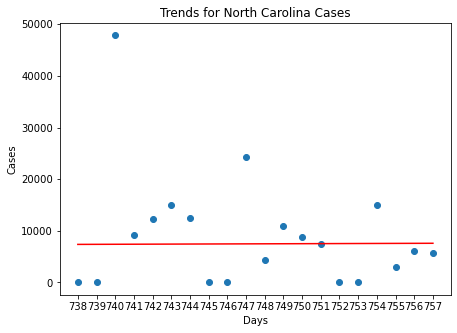

In [860]:
plt.figure(figsize=(7,5))
plt.xticks(X_test)
plt.title('Trends for North Carolina Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test,y_test_c)
plt.plot(X_test,lr_pred_test_c, color='red')

## Linear Regression for new deaths

In [861]:
lr1 = LinearRegression()
lr1.fit(X_train,y_train_d)

LinearRegression()

In [862]:
lr_pred_test_d = lr1.predict(X_test)
lr_pred_test_d

array([39.84442653, 39.87344548, 39.90246443, 39.93148338, 39.96050233,
       39.98952129, 40.01854024, 40.04755919, 40.07657814, 40.10559709,
       40.13461605, 40.163635  , 40.19265395, 40.2216729 , 40.25069185,
       40.2797108 , 40.30872976, 40.33774871, 40.36676766, 40.39578661])

### Calcluate error using RMSE for Linear Regression.

In [863]:
# https://stackoverflow.com/a/18623635
rms_d = sqrt(mean_squared_error(y_test_d, lr_pred_test_d))
rms_d

65.19625352690974

## Polynomial Regression Model

### For New deaths

In [864]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [865]:
# polynomial features with degree 2
pl_rg2_d = PolynomialRegression(2)
pl_rg2_d.fit(X_train, y_train_d)
py_test_pred2_d = pl_rg2_d.predict(X_test)

In [866]:
py_test_pred2_d

array([25.60521429, 25.51165753, 25.41774954, 25.32349034, 25.22887992,
       25.13391828, 25.03860541, 24.94294133, 24.84692603, 24.75055951,
       24.65384177, 24.5567728 , 24.45935262, 24.36158122, 24.2634586 ,
       24.16498476, 24.0661597 , 23.96698342, 23.86745592, 23.7675772 ])

In [867]:
# polynomial features with degree 3
pl_rg3_d = PolynomialRegression(3)
pl_rg3_d.fit(X_train, y_train_d)
py_test_pred3_d = pl_rg3_d.predict(X_test)

In [868]:
py_test_pred3_d

array([40.52959611, 40.6929871 , 40.85786747, 41.02424248, 41.19211741,
       41.36149751, 41.53238806, 41.70479433, 41.87872157, 42.05417505,
       42.23116005, 42.40968183, 42.58974565, 42.77135678, 42.95452048,
       43.13924203, 43.32552669, 43.51337972, 43.7028064 , 43.89381198])

### RMSE for polynomial features of new deaths

In [869]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_d = sqrt(mean_squared_error(y_test_d, py_test_pred2_d))
poly_rmse2_d

74.33133528369275

In [870]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_d = sqrt(mean_squared_error(y_test_d, py_test_pred3_d))
poly_rmse3_d

64.06900448269653

## Trend for North Carolina Deaths

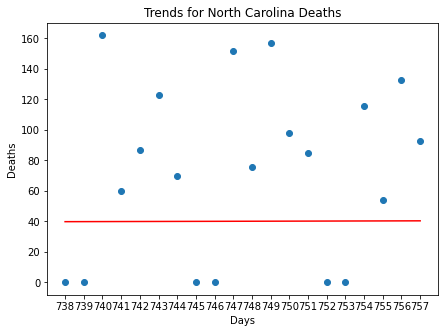

In [871]:
plt.figure(figsize=(7,5))
plt.xticks(X_test)
plt.title('Trends for North Carolina Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.scatter(X_test,y_test_d)
plt.plot(X_test,lr_pred_test_d, color='red')

## Trend Line for North Carolina cases

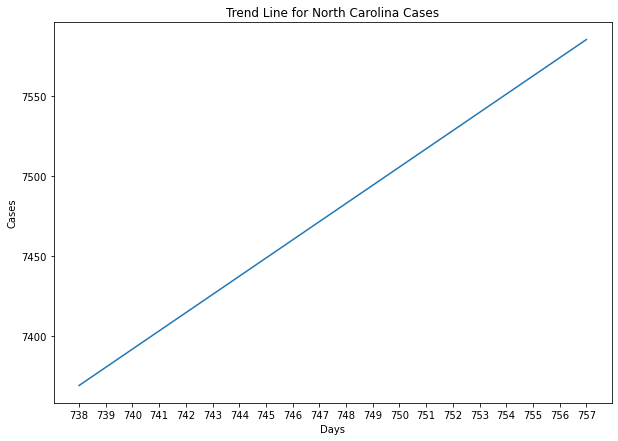

In [872]:
plt.figure(figsize=(10,7))
plt.xticks(X_test)
plt.title('Trend Line for North Carolina Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test,lr_pred_test_c)

### Confidence Intervals for North Carolina Cases

In [873]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [874]:
for i in lr_pred_test_c:
    print("The confidence interval is [",get_prediction_interval(i,y_test_c, lr_pred_test_c)[0],
          ',',get_prediction_interval(i,y_test_c, lr_pred_test_c)[2],"]")

The confidence interval is [ -15568.330780253998 , 30307.137916613872 ]
The confidence interval is [ -15556.964172611008 , 30318.504524256867 ]
The confidence interval is [ -15545.597564968019 , 30329.871131899854 ]
The confidence interval is [ -15534.230957325028 , 30341.237739542845 ]
The confidence interval is [ -15522.864349682037 , 30352.604347185836 ]
The confidence interval is [ -15511.497742039046 , 30363.970954828827 ]
The confidence interval is [ -15500.131134396055 , 30375.337562471817 ]
The confidence interval is [ -15488.764526753064 , 30386.70417011481 ]
The confidence interval is [ -15477.397919110073 , 30398.0707777578 ]
The confidence interval is [ -15466.031311467083 , 30409.43738540079 ]
The confidence interval is [ -15454.664703824094 , 30420.80399304378 ]
The confidence interval is [ -15443.298096181103 , 30432.170600686768 ]
The confidence interval is [ -15431.931488538112 , 30443.537208329763 ]
The confidence interval is [ -15420.564880895121 , 30454.90381597275 

In [875]:
upper, lower = [], []
for i in range(len(X_test)):
    lower.append(get_prediction_interval(i,y_test_c, lr_pred_test_c)[0])
    upper.append(get_prediction_interval(i,y_test_c, lr_pred_test_c)[2])

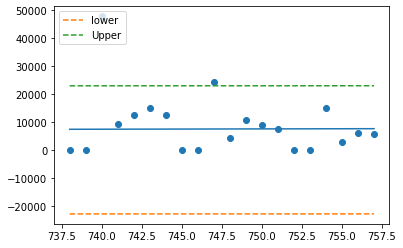

In [876]:
plt.scatter(X_test,y_test_c)
plt.plot(X_test,lr_pred_test_c)
plt.plot(X_test,lower,'--',label='lower')
plt.plot(X_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Cases (forecast)

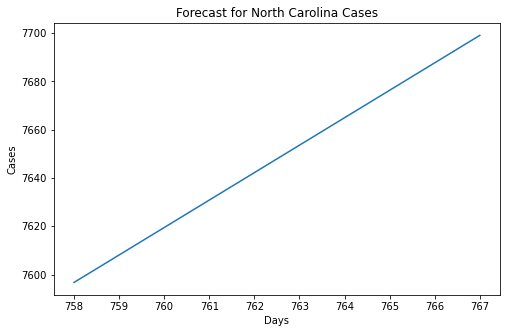

In [877]:
future_days = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for North Carolina Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(future_days,lr.predict(future_days.reshape(-1, 1)))  

## Trend Line for North Carolina Deaths

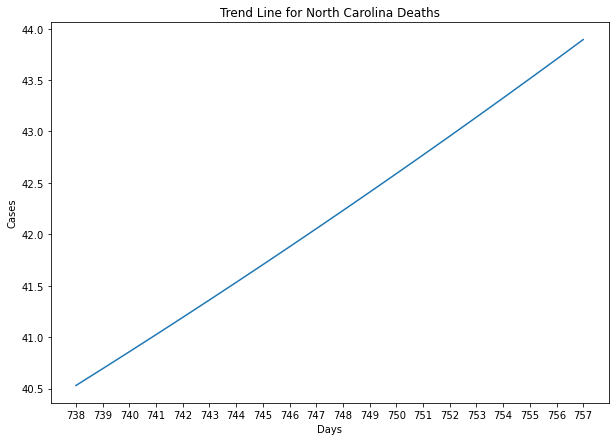

In [878]:
plt.figure(figsize=(10,7))
plt.xticks(X_test)
plt.title('Trend Line for North Carolina Deaths')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test,py_test_pred3_d)

### Confidence Intervals for North Carolina Deaths

In [879]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [880]:
for i in lr_pred_test_d:
    print("The confidence interval is [",get_prediction_interval(i,y_test_d, py_test_pred3_d)[0],
          ',',get_prediction_interval(i,y_test_d, py_test_pred3_d)[2],"]")

The confidence interval is [ -92.52107581583665 , 172.2099288713233 ]
The confidence interval is [ -92.49205686407578 , 172.23894782308417 ]
The confidence interval is [ -92.46303791231492 , 172.26796677484504 ]
The confidence interval is [ -92.43401896055404 , 172.2969857266059 ]
The confidence interval is [ -92.40500000879318 , 172.32600467836676 ]
The confidence interval is [ -92.3759810570323 , 172.35502363012765 ]
The confidence interval is [ -92.34696210527144 , 172.3840425818885 ]
The confidence interval is [ -92.31794315351057 , 172.4130615336494 ]
The confidence interval is [ -92.2889242017497 , 172.44208048541026 ]
The confidence interval is [ -92.25990524998883 , 172.47109943717112 ]
The confidence interval is [ -92.23088629822797 , 172.50011838893198 ]
The confidence interval is [ -92.2018673464671 , 172.52913734069284 ]
The confidence interval is [ -92.17284839470622 , 172.55815629245373 ]
The confidence interval is [ -92.14382944294536 , 172.5871752442146 ]
The confidence

In [881]:
upper, lower = [], []
for i in range(len(X_test)):
    lower.append(get_prediction_interval(i,y_test_d, py_test_pred3_d)[0])
    upper.append(get_prediction_interval(i,y_test_d, py_test_pred3_d)[2])

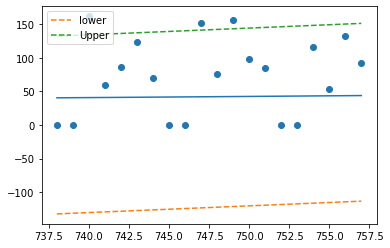

In [882]:
plt.scatter(X_test,y_test_d)
plt.plot(X_test,py_test_pred3_d)
plt.plot(X_test,lower,'--',label='lower')
plt.plot(X_test,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for deaths (forecast)

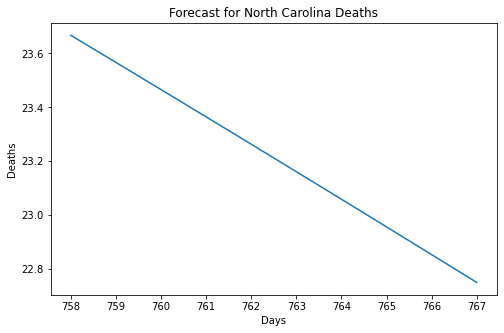

In [883]:
future_days = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for North Carolina Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(future_days,pl_rg2_d.predict(future_days.reshape(-1, 1)))  

### Getting total cases by counties

In [884]:
nc_data1 = nc_data.groupby(['County Name'])['Cases'].sum()
nc_data1 = nc_data1.reset_index()
nc_data1

,County Name,Cases
0,Alamance County,10156950
1,Alexander County,2387775
2,Alleghany County,612638
3,Anson County,1443062
4,Ashe County,1238261
...,...,...
95,Wayne County,6557483
96,Wilkes County,3889575
97,Wilson County,5186820
98,Yadkin County,2306540


### The top 5 infected counties

In [885]:
nc_data1.sort_values('Cases',ascending=False)

,County Name,Cases
59,Mecklenburg County,62311489
91,Wake County,50710853
40,Guilford County,25661074
33,Forsyth County,20009859
25,Cumberland County,16521939
...,...,...
37,Graham County,427159
36,Gates County,400406
14,Camden County,384240
47,Hyde County,332351


**The top 5 counties which has high number of cases are 'Mecklenburg County', 'Wake County', 'Guilford County', 
'Forsyth County', 'Cumberland County'**

In [886]:
mck_cnty = nc_data[nc_data['County Name']=='Mecklenburg County ']
wak_cnty = nc_data[nc_data['County Name']=='Wake County ']
gui_cnty = nc_data[nc_data['County Name']=='Guilford County ']
for_cnty = nc_data[nc_data['County Name']=='Forsyth County ']
cum_cnty = nc_data[nc_data['County Name']=='Cumberland County ']

### Finding first day infections

In [887]:
# The function to get first day of infections
def first_day_infections(area):
    return next(x[0] for x in enumerate(list(area['Cases'].values)) if x[1] > 0)

In [888]:
print("The first day infection in Mecklenburg County is: ",first_day_infections(mck_cnty))
print("The first day infection in Wake County is: ",first_day_infections(wak_cnty))
print("The first day infection in Guilford County is: ",first_day_infections(gui_cnty))
print("The first day infection in Forsyth County is: ",first_day_infections(for_cnty))
print("The first day infection in Cumberland County is: ",first_day_infections(cum_cnty))

The first day infection in Mecklenburg County is:  49
The first day infection in Wake County is:  41
The first day infection in Guilford County is:  56
The first day infection in Forsyth County is:  49
The first day infection in Cumberland County is:  59


In [889]:
mck_cnty_f = mck_cnty[49:]
wak_cnty_f = wak_cnty[41:]
gui_cnty_f = gui_cnty[56:]
for_cnty_f = for_cnty[49:]
cum_cnty_f = cum_cnty[59:]

In [890]:
mck_cnty1 = mck_cnty_f.groupby('Date')[['Cases','Death']].sum()
mck_cnty1 = mck_cnty1.reset_index()
wak_cnty1 = wak_cnty_f.groupby('Date')[['Cases','Death']].sum()
wak_cnty1 = wak_cnty1.reset_index()
gui_cnty1 = gui_cnty_f.groupby('Date')[['Cases','Death']].sum()
gui_cnty1 = gui_cnty1.reset_index()
for_cnty1 = for_cnty_f.groupby('Date')[['Cases','Death']].sum()
for_cnty1 = for_cnty1.reset_index()
cum_cnty1 = cum_cnty_f.groupby('Date')[['Cases','Death']].sum()
cum_cnty1 = cum_cnty1.reset_index()

In [891]:
mck_cnty1['new_cases'] = mck_cnty1['Cases'].diff()
mck_cnty1['new_deaths'] = mck_cnty1['Death'].diff()
wak_cnty1['new_cases'] = wak_cnty1['Cases'].diff()
wak_cnty1['new_deaths'] = wak_cnty1['Death'].diff()
gui_cnty1['new_cases'] = gui_cnty1['Cases'].diff()
gui_cnty1['new_deaths'] = gui_cnty1['Death'].diff()
for_cnty1['new_cases'] = for_cnty1['Cases'].diff()
for_cnty1['new_deaths'] = for_cnty1['Death'].diff()
cum_cnty1['new_cases'] = cum_cnty1['Cases'].diff()
cum_cnty1['new_deaths'] = cum_cnty1['Death'].diff()


In [892]:
# Removing the negative values
def non_neg_values(x):
    if x <=0:
        return 0
    else:
        return x


In [893]:
mck_cnty1['new_cases'].apply(non_neg_values)
mck_cnty1['new_deaths'].apply(non_neg_values)
wak_cnty1['new_cases'].apply(non_neg_values)
wak_cnty1['new_deaths'].apply(non_neg_values)
gui_cnty1['new_cases'].apply(non_neg_values)
gui_cnty1['new_deaths'].apply(non_neg_values)
for_cnty1['new_cases'].apply(non_neg_values)
for_cnty1['new_deaths'].apply(non_neg_values)
cum_cnty1['new_cases'].apply(non_neg_values)
cum_cnty1['new_deaths'].apply(non_neg_values)
''

''

In [894]:
mck_cnty.head()

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
1477342,37119,Mecklenburg County,NC,37,2020-01-22,0,0,1110356
1477343,37119,Mecklenburg County,NC,37,2020-01-23,0,0,1110356
1477344,37119,Mecklenburg County,NC,37,2020-01-24,0,0,1110356
1477345,37119,Mecklenburg County,NC,37,2020-01-25,0,0,1110356
1477346,37119,Mecklenburg County,NC,37,2020-01-26,0,0,1110356


## Mecklenburg County Analysis

In [895]:
mck_cnty1 = mck_cnty1[1:]
mck_cnty1

,Date,Cases,Death,new_cases,new_deaths
1,2020-03-12,2,0,0.0,0.0
2,2020-03-13,2,0,0.0,0.0
3,2020-03-14,4,0,2.0,0.0
4,2020-03-15,4,0,0.0,0.0
5,2020-03-16,7,0,3.0,0.0
...,...,...,...,...,...
704,2022-02-13,269472,1501,0.0,0.0
705,2022-02-14,270639,1511,1167.0,10.0
706,2022-02-15,270861,1512,222.0,1.0
707,2022-02-16,271580,1520,719.0,8.0


In [896]:
mck_cnty1['Day_count'] = np.arange(1,len(mck_cnty1)+1)
mck_cnty1

,Date,Cases,Death,new_cases,new_deaths,Day_count
1,2020-03-12,2,0,0.0,0.0,1
2,2020-03-13,2,0,0.0,0.0,2
3,2020-03-14,4,0,2.0,0.0,3
4,2020-03-15,4,0,0.0,0.0,4
5,2020-03-16,7,0,3.0,0.0,5
...,...,...,...,...,...,...
704,2022-02-13,269472,1501,0.0,0.0,704
705,2022-02-14,270639,1511,1167.0,10.0,705
706,2022-02-15,270861,1512,222.0,1.0,706
707,2022-02-16,271580,1520,719.0,8.0,707



### Modelling for Mecklenburg County

In [897]:
X_train_mck = mck_cnty1['Day_count'][:688]
y_train_mck_c = mck_cnty1['new_cases'][:688]
y_train_mck_d = mck_cnty1['new_deaths'][:688]
X_test_mck = mck_cnty1['Day_count'][688:]
y_test_mck_c = mck_cnty1['new_cases'][688:]
y_test_mck_d = mck_cnty1['new_deaths'][688:]

In [898]:
X_train_mck = np.array(X_train_mck).reshape(-1,1)
X_test_mck = np.array(X_test_mck).reshape(-1,1)

## Linear Regression for new cases

In [899]:
lr = LinearRegression()
lr.fit(X_train_mck,y_train_mck_c)

LinearRegression()

In [900]:
lr_pred_test_mck_c = lr.predict(X_test_mck)
lr_pred_test_mck_c

array([772.3150198 , 773.47380543, 774.63259105, 775.79137668,
       776.9501623 , 778.10894793, 779.26773355, 780.42651918,
       781.5853048 , 782.74409043, 783.90287605, 785.06166167,
       786.2204473 , 787.37923292, 788.53801855, 789.69680417,
       790.8555898 , 792.01437542, 793.17316105, 794.33194667])

### Calcluate error using RMSE for Linear Regression.

In [901]:
# https://stackoverflow.com/a/18623635
rms_mck_c = sqrt(mean_squared_error(y_test_mck_c, lr_pred_test_mck_c))
rms_mck_c

981.5995763853206

## Polynomial Regression Model

### For New cases

In [902]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [903]:
# polynomial features with degree 2
pl_rg2_mck_c = PolynomialRegression(2)
pl_rg2_mck_c.fit(X_train_mck, y_train_mck_c)
py_test_pred2_mck_c = pl_rg2_mck_c.predict(X_test_mck)

In [904]:
py_test_pred2_mck_c

array([1123.05344323, 1127.26655475, 1131.48851938, 1135.71933714,
       1139.95900801, 1144.207532  , 1148.46490911, 1152.73113934,
       1157.00622269, 1161.29015916, 1165.58294874, 1169.88459145,
       1174.19508727, 1178.51443621, 1182.84263827, 1187.17969345,
       1191.52560174, 1195.88036316, 1200.24397769, 1204.61644534])

In [905]:
# polynomial features with degree 3 for new cases
pl_rg3_mck_c = PolynomialRegression(3)
pl_rg3_mck_c.fit(X_train_mck, y_train_mck_c)
py_test_pred3_mck_c = pl_rg3_mck_c.predict(X_test_mck)

In [906]:
py_test_pred3_mck_c

array([1833.42993542, 1850.01535159, 1866.69927526, 1883.48196593,
       1900.36368307, 1917.34468619, 1934.42523478, 1951.60558833,
       1968.88600633, 1986.26674827, 2003.74807364, 2021.33024194,
       2039.01351265, 2056.79814528, 2074.6843993 , 2092.67253422,
       2110.76280952, 2128.9554847 , 2147.25081924, 2165.64907264])

### RMSE for polynomial features of new cases

In [907]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_mck_c = sqrt(mean_squared_error(y_test_mck_c, py_test_pred2_mck_c))
poly_rmse2_mck_c 

1062.9384739628988

In [908]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_c = sqrt(mean_squared_error(y_test_mck_c, py_test_pred3_mck_c))
poly_rmse3_c

1591.0186780265758

## Trend for Mecklenburg County cases

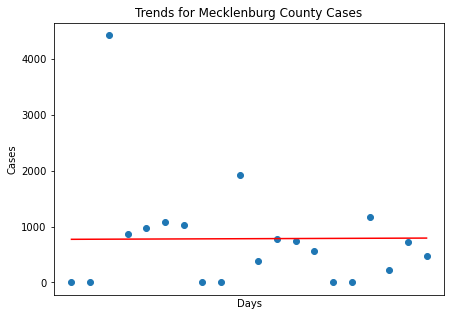

In [909]:
plt.figure(figsize=(7,5))
plt.xticks(X_test)
plt.title('Trends for Mecklenburg County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_mck,y_test_mck_c)
plt.plot(X_test_mck,lr_pred_test_mck_c, color='red')

## Linear Regression for new deaths

In [910]:
lr1 = LinearRegression()
lr1.fit(X_train_mck,y_train_mck_d)

LinearRegression()

In [911]:
lr_pred_test_mck_d = lr1.predict(X_test_mck)
lr_pred_test_mck_d

array([2.32169696, 2.32239028, 2.3230836 , 2.32377692, 2.32447024,
       2.32516355, 2.32585687, 2.32655019, 2.32724351, 2.32793683,
       2.32863015, 2.32932346, 2.33001678, 2.3307101 , 2.33140342,
       2.33209674, 2.33279006, 2.33348337, 2.33417669, 2.33487001])

### Calcluate error using RMSE for Linear Regression.

In [912]:
# https://stackoverflow.com/a/18623635
rms_d = sqrt(mean_squared_error(y_test_mck_d, lr_pred_test_mck_d))
rms_d

5.604849119713982

## Polynomial Regression Model

### For New deaths

In [913]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [914]:
# polynomial features with degree 2
pl_rg2_mck_d = PolynomialRegression(2)
pl_rg2_mck_d.fit(X_train_mck, y_train_mck_d)
py_test_pred2_mck_d = pl_rg2_mck_d.predict(X_test_mck)

In [915]:
py_test_pred2_mck_d

array([1.85721271, 1.85386117, 1.85049791, 1.84712293, 1.84373622,
       1.84033778, 1.83692762, 1.83350574, 1.83007214, 1.8266268 ,
       1.82316975, 1.81970097, 1.81622047, 1.81272824, 1.80922429,
       1.80570861, 1.80218121, 1.79864208, 1.79509123, 1.79152866])

In [916]:
# polynomial features with degree 3
pl_rg3_mck_d = PolynomialRegression(3)
pl_rg3_mck_d.fit(X_train_mck, y_train_mck_d)
py_test_pred3_mck_d = pl_rg3_mck_d.predict(X_test_mck)

In [917]:
py_test_pred3_mck_d

array([3.47686535, 3.50172257, 3.52677247, 3.55201566, 3.57745271,
       3.60308423, 3.62891079, 3.65493301, 3.68115146, 3.70756674,
       3.73417944, 3.76099015, 3.78799946, 3.81520797, 3.84261627,
       3.87022494, 3.89803459, 3.92604579, 3.95425915, 3.98267526])

### RMSE for polynomial features of new deaths

In [918]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_mck_d = sqrt(mean_squared_error(y_test_mck_d, py_test_pred2_mck_d))
poly_rmse2_mck_d

5.805787357458959

In [919]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_mck_d = sqrt(mean_squared_error(y_test_mck_d, py_test_pred3_mck_d))
poly_rmse3_mck_d

5.265946148631206

## Trend for Mecklenburg County Deaths

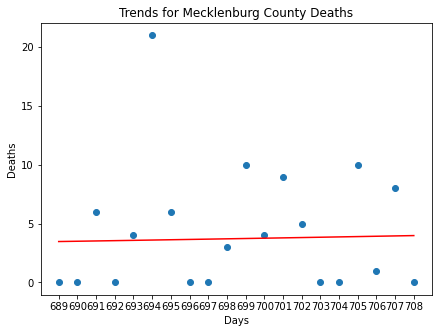

In [920]:
# plotting for best model i.e polynomial model with degree 3
plt.figure(figsize=(7,5))
plt.xticks(X_test_mck)
plt.title('Trends for Mecklenburg County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.scatter(X_test_mck,y_test_mck_d)
plt.plot(X_test_mck,py_test_pred3_mck_d, color='red')

## Member Task 2

## Trend Line for Mecklenburg County cases

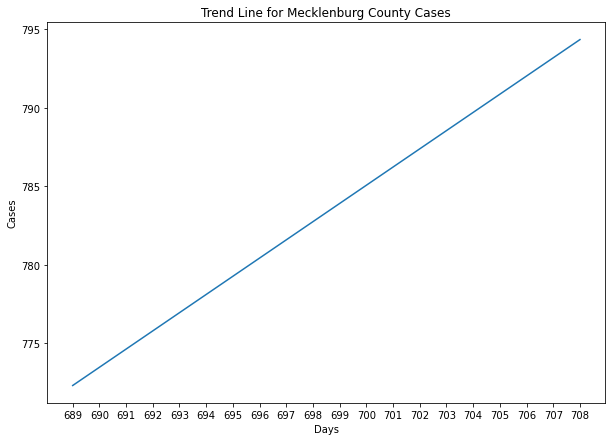

In [921]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_mck)
plt.title('Trend Line for Mecklenburg County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_mck,lr_pred_test_mck_c)

### Confidence Intervals for Mecklenburg Cases

In [922]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [923]:
for i in lr_pred_test_mck_c:
    print("The confidence interval is [",get_prediction_interval(i,y_test_mck_c, lr_pred_test_mck_c)[0],
          ',',get_prediction_interval(i,y_test_mck_c, lr_pred_test_mck_c)[2],"]")

The confidence interval is [ -1255.6534507166266 , 2800.283490322598 ]
The confidence interval is [ -1254.4946650919242 , 2801.4422759473005 ]
The confidence interval is [ -1253.335879467222 , 2802.6010615720024 ]
The confidence interval is [ -1252.1770938425195 , 2803.759847196705 ]
The confidence interval is [ -1251.018308217817 , 2804.9186328214073 ]
The confidence interval is [ -1249.859522593115 , 2806.0774184461097 ]
The confidence interval is [ -1248.7007369684125 , 2807.236204070812 ]
The confidence interval is [ -1247.54195134371 , 2808.3949896955146 ]
The confidence interval is [ -1246.3831657190078 , 2809.553775320217 ]
The confidence interval is [ -1245.2243800943054 , 2810.7125609449195 ]
The confidence interval is [ -1244.065594469603 , 2811.871346569622 ]
The confidence interval is [ -1242.9068088449008 , 2813.030132194324 ]
The confidence interval is [ -1241.7480232201983 , 2814.1889178190263 ]
The confidence interval is [ -1240.589237595496 , 2815.3477034437287 ]
The c

In [924]:
upper, lower = [], []
for i in range(len(X_test_mck)):
    lower.append(get_prediction_interval(i,y_test_mck_c, lr_pred_test_mck_c)[0])
    upper.append(get_prediction_interval(i,y_test_mck_c, lr_pred_test_mck_c)[2])

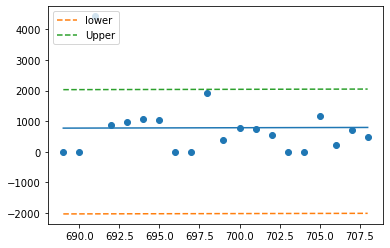

In [925]:
plt.scatter(X_test_mck,y_test_mck_c)
plt.plot(X_test_mck,lr_pred_test_mck_c)
plt.plot(X_test_mck,lower,'--',label='lower')
plt.plot(X_test_mck,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Cases (forecast)

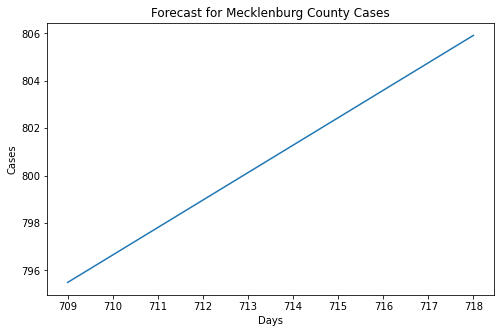

In [926]:
future_days = np.arange(709,719)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for Mecklenburg County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(future_days,lr.predict(future_days.reshape(-1, 1)))  

## Trend Line for Mecklenburg County Deaths

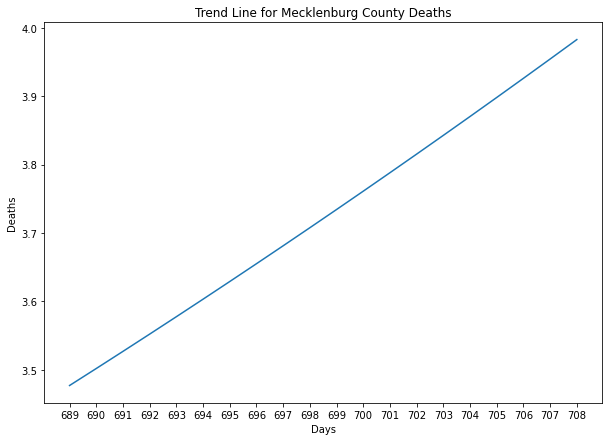

In [927]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_mck)
plt.title('Trend Line for Mecklenburg County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(X_test_mck,py_test_pred3_mck_d)

### Confidence Intervals for Mecklenburg Cases

In [928]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [929]:
for i in py_test_pred3_mck_d:
    print("The confidence interval is [",get_prediction_interval(i,y_test_mck_d, py_test_pred3_mck_d)[0],
          ',',get_prediction_interval(i,y_test_mck_d, py_test_pred3_mck_d)[2],"]")

The confidence interval is [ -7.402492190684231 , 14.3562228980155 ]
The confidence interval is [ -7.377634973782853 , 14.381080114916877 ]
The confidence interval is [ -7.352585069837672 , 14.406130018862058 ]
The confidence interval is [ -7.3273418872097364 , 14.431373201489993 ]
The confidence interval is [ -7.301904834260067 , 14.456810254439663 ]
The confidence interval is [ -7.276273319349705 , 14.482441769350025 ]
The confidence interval is [ -7.250446750839671 , 14.50826833786006 ]
The confidence interval is [ -7.224424537091013 , 14.534290551608716 ]
The confidence interval is [ -7.198206086464768 , 14.560509002234962 ]
The confidence interval is [ -7.171790807321947 , 14.586924281377783 ]
The confidence interval is [ -7.145178108023599 , 14.61353698067613 ]
The confidence interval is [ -7.11836739693076 , 14.64034769176897 ]
The confidence interval is [ -7.09135808240445 , 14.66735700629528 ]
The confidence interval is [ -7.064149572805717 , 14.694565515894013 ]
The confidenc

In [930]:
upper, lower = [], []
for i in range(len(X_test_mck)):
    lower.append(get_prediction_interval(i,y_test_mck_d, py_test_pred3_mck_d)[0])
    upper.append(get_prediction_interval(i,y_test_mck_d, py_test_pred3_mck_d)[2])

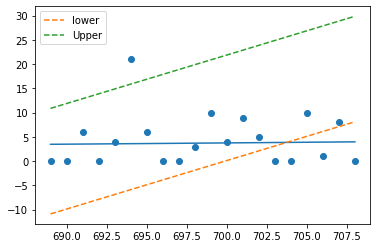

In [931]:
plt.scatter(X_test_mck,y_test_mck_d)
plt.plot(X_test_mck,py_test_pred3_mck_d)
plt.plot(X_test_mck,lower,'--',label='lower')
plt.plot(X_test_mck,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Deaths (forecast)

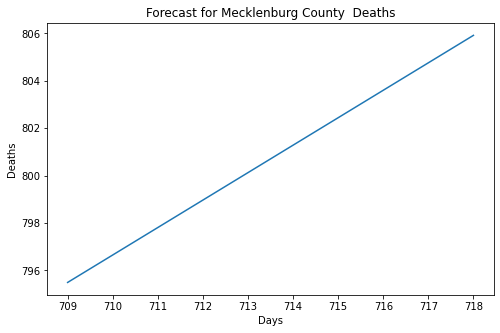

In [932]:
future_days = np.arange(709,719)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for Mecklenburg County  Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(future_days,lr.predict(future_days.reshape(-1, 1)))  

## Wake County Analysis

In [933]:
wak_cnty1 = wak_cnty1[1:]
wak_cnty1

,Date,Cases,Death,new_cases,new_deaths
1,2020-03-04,1,0,0.0,0.0
2,2020-03-05,1,0,0.0,0.0
3,2020-03-06,1,0,0.0,0.0
4,2020-03-07,1,0,0.0,0.0
5,2020-03-08,1,0,0.0,0.0
...,...,...,...,...,...
712,2022-02-13,278746,981,0.0,0.0
713,2022-02-14,280703,995,1957.0,14.0
714,2022-02-15,281077,995,374.0,0.0
715,2022-02-16,281534,999,457.0,4.0



### Modelling for Wake County

In [934]:
wak_cnty1['Day_count'] = np.arange(1,len(wak_cnty1)+1)
wak_cnty1

,Date,Cases,Death,new_cases,new_deaths,Day_count
1,2020-03-04,1,0,0.0,0.0,1
2,2020-03-05,1,0,0.0,0.0,2
3,2020-03-06,1,0,0.0,0.0,3
4,2020-03-07,1,0,0.0,0.0,4
5,2020-03-08,1,0,0.0,0.0,5
...,...,...,...,...,...,...
712,2022-02-13,278746,981,0.0,0.0,712
713,2022-02-14,280703,995,1957.0,14.0,713
714,2022-02-15,281077,995,374.0,0.0,714
715,2022-02-16,281534,999,457.0,4.0,715


In [935]:
X_train_wak = wak_cnty1['Day_count'][:696]
y_train_wak_c = wak_cnty1['new_cases'][:696]
y_train_wak_d = wak_cnty1['new_deaths'][:696]
X_test_wak = wak_cnty1['Day_count'][696:]
y_test_wak_c = wak_cnty1['new_cases'][696:]
y_test_wak_d = wak_cnty1['new_deaths'][696:]

In [936]:
X_train_wak = np.array(X_train_wak).reshape(-1,1)
X_test_wak = np.array(X_test_wak).reshape(-1,1)

## Linear Regression for new cases

In [937]:
lr = LinearRegression()
lr.fit(X_train_wak,y_train_wak_c)

LinearRegression()

In [938]:
lr_pred_test_wak_c = lr.predict(X_test_wak)
lr_pred_test_wak_c

array([939.45688828, 941.07848904, 942.7000898 , 944.32169057,
       945.94329133, 947.56489209, 949.18649285, 950.80809361,
       952.42969437, 954.05129513, 955.67289589, 957.29449666,
       958.91609742, 960.53769818, 962.15929894, 963.7808997 ,
       965.40250046, 967.02410122, 968.64570198, 970.26730275])

### Calcluate error using RMSE for Linear Regression.

In [939]:
# https://stackoverflow.com/a/18623635
rms_wak_c = sqrt(mean_squared_error(y_test_wak_c, lr_pred_test_wak_c))
rms_wak_c

1364.5853036646934

## Polynomial Regression Model

### For New cases

In [940]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [941]:
# polynomial features with degree 2
pl_rg2_wak_c = PolynomialRegression(2)
pl_rg2_wak_c.fit(X_train_wak, y_train_wak_c)
py_test_pred2_wak_c = pl_rg2_wak_c.predict(X_test_wak)

In [942]:
py_test_pred2_wak_c

array([1507.96046077, 1514.47592299, 1521.00540773, 1527.548915  ,
       1534.10644479, 1540.67799711, 1547.26357196, 1553.86316933,
       1560.47678923, 1567.10443165, 1573.7460966 , 1580.40178407,
       1587.07149407, 1593.7552266 , 1600.45298165, 1607.16475922,
       1613.89055933, 1620.63038196, 1627.38422711, 1634.15209479])

In [943]:
# polynomial features with degree 3 for new cases
pl_rg3_wak_c = PolynomialRegression(3)
pl_rg3_wak_c.fit(X_train_wak, y_train_wak_c)
py_test_pred3_wak_c = pl_rg3_wak_c.predict(X_test_wak)

In [944]:
py_test_pred3_wak_c

array([2420.74782158, 2442.97841771, 2465.33560895, 2487.8197174 ,
       2510.43106517, 2533.16997434, 2556.03676701, 2579.03176528,
       2602.15529125, 2625.40766701, 2648.78921466, 2672.30025628,
       2695.94111399, 2719.71210988, 2743.61356603, 2767.64580455,
       2791.80914754, 2816.10391709, 2840.53043529, 2865.08902424])

### RMSE for polynomial features of new cases

In [945]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_wak_c = sqrt(mean_squared_error(y_test_wak_c, py_test_pred2_wak_c))
poly_rmse2_wak_c 

1454.0713370429671

In [946]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_c = sqrt(mean_squared_error(y_test_wak_c, py_test_pred3_wak_c))
poly_rmse3_c

2097.0170219026268

## Trend for Wake County Cases

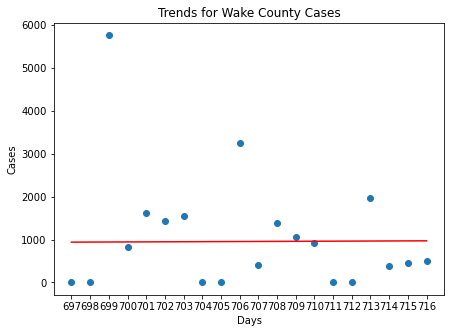

In [947]:
# plotting for best model i.e linear regression model
plt.figure(figsize=(7,5))
plt.xticks(X_test_wak)
plt.title('Trends for Wake County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_wak,y_test_wak_c)
plt.plot(X_test_wak,lr_pred_test_wak_c, color='red')

## Linear Regression for new deaths

In [948]:
lr1 = LinearRegression()
lr1.fit(X_train_wak,y_train_wak_d)

LinearRegression()

In [949]:
lr_pred_test_wak_d = lr1.predict(X_test_wak)
lr_pred_test_wak_d

array([1.44891259, 1.44908345, 1.44925431, 1.44942517, 1.44959603,
       1.4497669 , 1.44993776, 1.45010862, 1.45027948, 1.45045034,
       1.4506212 , 1.45079206, 1.45096292, 1.45113378, 1.45130464,
       1.4514755 , 1.45164636, 1.45181722, 1.45198808, 1.45215894])

### Calcluate error using RMSE for Linear Regression.

In [950]:
# https://stackoverflow.com/a/18623635
rms_d = sqrt(mean_squared_error(y_test_wak_d, lr_pred_test_wak_d))
rms_d

3.7261178787616682

## Polynomial Regression Model

### For New deaths

In [951]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [952]:
# polynomial features with degree 2
pl_rg2_wak_d = PolynomialRegression(2)
pl_rg2_wak_d.fit(X_train_wak, y_train_wak_d)
py_test_pred2_wak_d = pl_rg2_wak_d.predict(X_test_wak)

In [953]:
py_test_pred2_wak_d

array([0.39000961, 0.3810651 , 0.37209446, 0.36309771, 0.35407483,
       0.34502584, 0.33595073, 0.3268495 , 0.31772216, 0.30856869,
       0.29938911, 0.2901834 , 0.28095158, 0.27169364, 0.26240959,
       0.25309941, 0.24376311, 0.2344007 , 0.22501217, 0.21559752])

In [954]:
# polynomial features with degree 3
pl_rg3_wak_d = PolynomialRegression(3)
pl_rg3_wak_d.fit(X_train_wak, y_train_wak_d)
py_test_pred3_wak_d = pl_rg3_wak_d.predict(X_test_wak)

In [955]:
py_test_pred3_wak_d

array([1.19108104, 1.19592828, 1.2008482 , 1.20584108, 1.2109072 ,
       1.21604685, 1.2212603 , 1.22654784, 1.23190975, 1.23734632,
       1.24285783, 1.24844455, 1.25410678, 1.2598448 , 1.26565888,
       1.27154932, 1.27751639, 1.28356037, 1.28968156, 1.29588022])

### RMSE for polynomial features of new deaths

In [956]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_wak_d = sqrt(mean_squared_error(y_test_wak_d, py_test_pred2_wak_d))
poly_rmse2_wak_d

4.0360309395541805

In [957]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_wak_d = sqrt(mean_squared_error(y_test_wak_d, py_test_pred3_wak_d))
poly_rmse3_wak_d

3.741358291284169

## Trend for Wake County Deaths

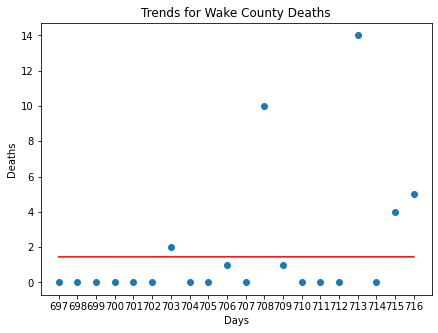

In [958]:
# plotting for best model i.e linear regression model
plt.figure(figsize=(7,5))
plt.xticks(X_test_wak)
plt.title('Trends for Wake County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.scatter(X_test_wak,y_test_wak_d)
plt.plot(X_test_wak,lr_pred_test_wak_d, color='red')

### Member Task 2

## Trend Line for Wake County cases

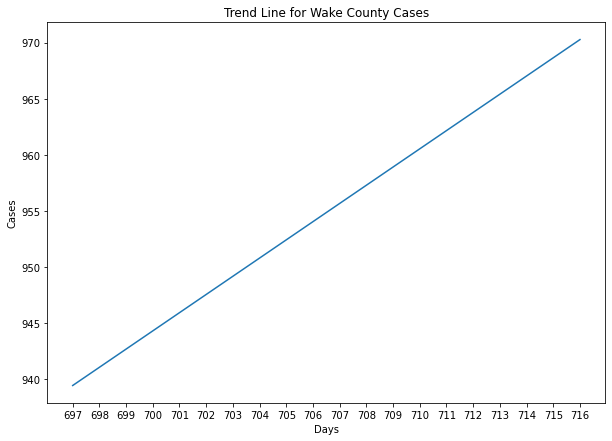

In [959]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_wak)
plt.title('Trend Line for Wake County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_wak,lr_pred_test_wak_c)

### Confidence Intervals for Wake Cases

In [960]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [961]:
for i in lr_pred_test_wak_c:
    print("The confidence interval is [",get_prediction_interval(i,y_test_wak_c, lr_pred_test_wak_c)[0],
          ',',get_prediction_interval(i,y_test_wak_c, lr_pred_test_wak_c)[2],"]")

The confidence interval is [ -1879.753752941485 , 3758.6675295064397 ]
The confidence interval is [ -1878.1321521802397 , 3760.289130267685 ]
The confidence interval is [ -1876.5105514189943 , 3761.91073102893 ]
The confidence interval is [ -1874.888950657749 , 3763.5323317901757 ]
The confidence interval is [ -1873.267349896504 , 3765.1539325514204 ]
The confidence interval is [ -1871.6457491352585 , 3766.775533312666 ]
The confidence interval is [ -1870.0241483740133 , 3768.3971340739113 ]
The confidence interval is [ -1868.402547612768 , 3770.0187348351565 ]
The confidence interval is [ -1866.780946851523 , 3771.6403355964017 ]
The confidence interval is [ -1865.1593460902775 , 3773.261936357647 ]
The confidence interval is [ -1863.5377453290323 , 3774.8835371188925 ]
The confidence interval is [ -1861.9161445677871 , 3776.505137880137 ]
The confidence interval is [ -1860.2945438065417 , 3778.126738641383 ]
The confidence interval is [ -1858.6729430452965 , 3779.748339402628 ]
The c

In [962]:
upper, lower = [], []
for i in range(len(X_test_wak)):
    lower.append(get_prediction_interval(i,y_test_wak_c, lr_pred_test_wak_c)[0])
    upper.append(get_prediction_interval(i,y_test_wak_c, lr_pred_test_wak_c)[2])

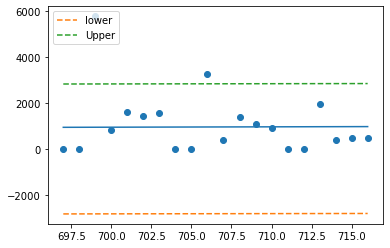

In [963]:
plt.scatter(X_test_wak,y_test_wak_c)
plt.plot(X_test_wak,lr_pred_test_wak_c)
plt.plot(X_test_wak,lower,'--',label='lower')
plt.plot(X_test_wak,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Cases (forecast)

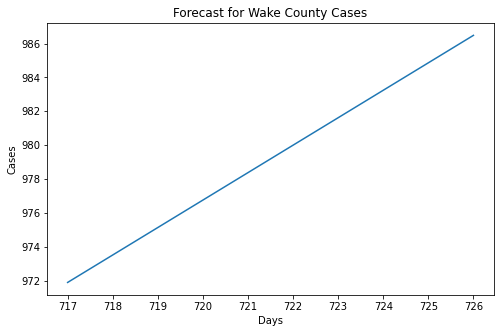

In [964]:
future_days = np.arange(717,727)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for Wake County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(future_days,lr.predict(future_days.reshape(-1, 1)))  

## Trend Line for Wake County Deaths

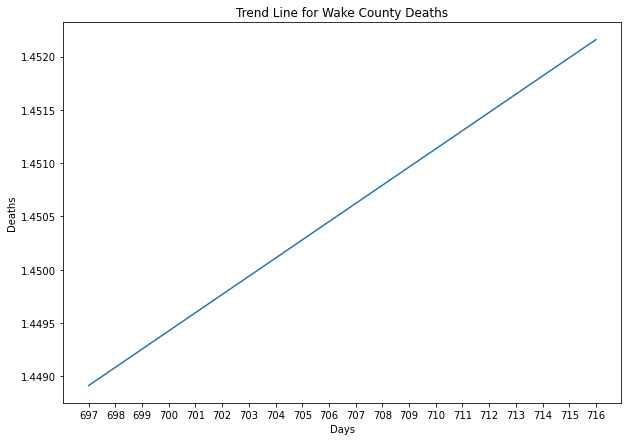

In [965]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_wak)
plt.title('Trend Line for Wake County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(X_test_wak,lr_pred_test_wak_d)

### Confidence Intervals for Wake Deaths

In [966]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [967]:
for i in lr_pred_test_wak_d:
    print("The confidence interval is [",get_prediction_interval(i,y_test_wak_d, lr_pred_test_wak_d)[0],
          ',',get_prediction_interval(i,y_test_wak_d, lr_pred_test_wak_d)[2],"]")

The confidence interval is [ -6.249185242729627 , 9.147010430854989 ]
The confidence interval is [ -6.24901438253459 , 9.147181291050027 ]
The confidence interval is [ -6.248843522339551 , 9.147352151245064 ]
The confidence interval is [ -6.2486726621445134 , 9.147523011440104 ]
The confidence interval is [ -6.248501801949475 , 9.147693871635141 ]
The confidence interval is [ -6.248330941754437 , 9.147864731830179 ]
The confidence interval is [ -6.2481600815594 , 9.148035592025217 ]
The confidence interval is [ -6.247989221364362 , 9.148206452220254 ]
The confidence interval is [ -6.247818361169323 , 9.148377312415292 ]
The confidence interval is [ -6.247647500974286 , 9.14854817261033 ]
The confidence interval is [ -6.247476640779247 , 9.148719032805369 ]
The confidence interval is [ -6.24730578058421 , 9.148889893000407 ]
The confidence interval is [ -6.247134920389172 , 9.149060753195444 ]
The confidence interval is [ -6.246964060194134 , 9.149231613390482 ]
The confidence interval 

In [968]:
upper, lower = [], []
for i in range(len(X_test_mck)):
    lower.append(get_prediction_interval(i,y_test_wak_d, lr_pred_test_wak_d)[0])
    upper.append(get_prediction_interval(i,y_test_wak_d, lr_pred_test_wak_d)[2])

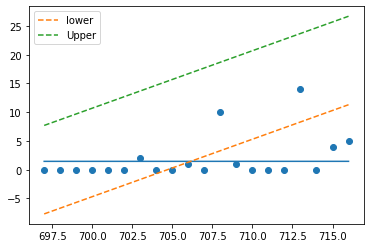

In [969]:
plt.scatter(X_test_wak,y_test_wak_d)
plt.plot(X_test_wak,lr_pred_test_wak_d)
plt.plot(X_test_wak,lower,'--',label='lower')
plt.plot(X_test_wak,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Deaths (forecast)

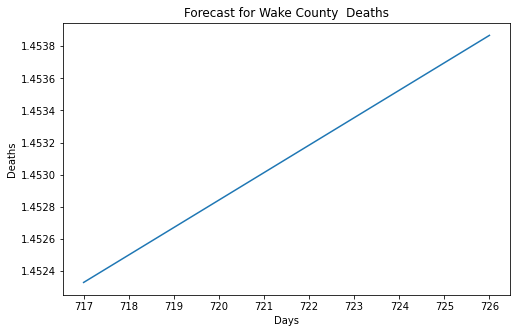

In [970]:
future_days = np.arange(717,727)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for Wake County  Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(future_days,lr1.predict(future_days.reshape(-1, 1)))  

## Guilford County Analysis

In [971]:
gui_cnty1 = gui_cnty1[1:]
gui_cnty1

,Date,Cases,Death,new_cases,new_deaths
1,2020-03-19,4,0,3.0,0.0
2,2020-03-20,4,0,0.0,0.0
3,2020-03-21,7,0,3.0,0.0
4,2020-03-22,11,0,4.0,0.0
5,2020-03-23,11,0,0.0,0.0
...,...,...,...,...,...
697,2022-02-13,111548,1032,0.0,0.0
698,2022-02-14,112159,1046,611.0,14.0
699,2022-02-15,112294,1048,135.0,2.0
700,2022-02-16,112510,1054,216.0,6.0



### Modelling for Guilford County

In [972]:
gui_cnty1['Day_count'] = np.arange(1,len(gui_cnty1)+1)
gui_cnty1

,Date,Cases,Death,new_cases,new_deaths,Day_count
1,2020-03-19,4,0,3.0,0.0,1
2,2020-03-20,4,0,0.0,0.0,2
3,2020-03-21,7,0,3.0,0.0,3
4,2020-03-22,11,0,4.0,0.0,4
5,2020-03-23,11,0,0.0,0.0,5
...,...,...,...,...,...,...
697,2022-02-13,111548,1032,0.0,0.0,697
698,2022-02-14,112159,1046,611.0,14.0,698
699,2022-02-15,112294,1048,135.0,2.0,699
700,2022-02-16,112510,1054,216.0,6.0,700


In [973]:
X_train_gui = gui_cnty1['Day_count'][:681]
y_train_gui_c = gui_cnty1['new_cases'][:681]
y_train_gui_d = gui_cnty1['new_deaths'][:681]
X_test_gui = gui_cnty1['Day_count'][681:]
y_test_gui_c = gui_cnty1['new_cases'][681:]
y_test_gui_d = gui_cnty1['new_deaths'][681:]

In [974]:
X_train_gui = np.array(X_train_gui).reshape(-1,1)
X_test_gui = np.array(X_test_gui).reshape(-1,1)

## Linear Regression for new cases

In [975]:
lr = LinearRegression()
lr.fit(X_train_gui,y_train_gui_c)

LinearRegression()

In [976]:
lr_pred_test_gui_c = lr.predict(X_test_gui)
lr_pred_test_gui_c

array([319.8125162 , 320.29409333, 320.77567046, 321.2572476 ,
       321.73882473, 322.22040186, 322.701979  , 323.18355613,
       323.66513326, 324.1467104 , 324.62828753, 325.10986466,
       325.5914418 , 326.07301893, 326.55459607, 327.0361732 ,
       327.51775033, 327.99932747, 328.4809046 , 328.96248173])

### Calcluate error using RMSE for Linear Regression.

In [977]:
# https://stackoverflow.com/a/18623635
rms_gui_c = sqrt(mean_squared_error(y_test_gui_c, lr_pred_test_gui_c))
rms_gui_c

429.3777266015937

## Polynomial Regression Model

### For New cases

In [978]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [979]:
# polynomial features with degree 2
pl_rg2_gui_c = PolynomialRegression(2)
pl_rg2_gui_c.fit(X_train_gui, y_train_gui_c)
py_test_pred2_gui_c = pl_rg2_gui_c.predict(X_test_gui)

In [980]:
py_test_pred2_gui_c

array([431.5197072 , 432.98404554, 434.45126166, 435.92135557,
       437.39432724, 438.8701767 , 440.34890394, 441.83050895,
       443.31499174, 444.80235231, 446.29259066, 447.78570678,
       449.28170069, 450.78057237, 452.28232183, 453.78694907,
       455.29445408, 456.80483687, 458.31809745, 459.8342358 ])

In [981]:
# polynomial features with degree 3 for new cases
pl_rg3_gui_c = PolynomialRegression(3)
pl_rg3_gui_c.fit(X_train_gui, y_train_gui_c)
py_test_pred3_gui_c = pl_rg3_gui_c.predict(X_test_gui)

In [982]:
py_test_pred3_gui_c

array([702.0543139 , 708.27879195, 714.54099506, 720.84102514,
       727.17898407, 733.55497374, 739.96909606, 746.4214529 ,
       752.91214617, 759.44127775, 766.00894954, 772.61526343,
       779.26032132, 785.94422509, 792.66707664, 799.42897786,
       806.23003065, 813.0703369 , 819.94999849, 826.86911733])

### RMSE for polynomial features of new cases

In [983]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_gui_c = sqrt(mean_squared_error(y_test_gui_c, py_test_pred2_gui_c))
poly_rmse2_gui_c 

444.36272751950656

In [984]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_c = sqrt(mean_squared_error(y_test_gui_c, py_test_pred3_gui_c))
poly_rmse3_c

612.7838998008868

## Trend for Guilford County Cases

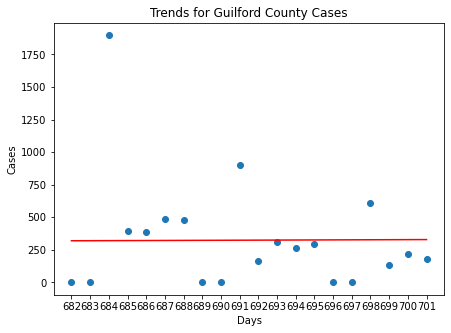

In [985]:
# plotting for best model i.e linear regression model
plt.figure(figsize=(7,5))
plt.xticks(X_test_gui)
plt.title('Trends for Guilford County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_gui,y_test_gui_c)
plt.plot(X_test_gui,lr_pred_test_gui_c, color='red')

## Linear Regression for new deaths

In [986]:
lr1 = LinearRegression()
lr1.fit(X_train_gui,y_train_gui_d)

LinearRegression()

In [987]:
lr_pred_test_gui_d = lr1.predict(X_test_gui)
lr_pred_test_gui_d

array([1.59809104, 1.59853157, 1.5989721 , 1.59941263, 1.59985316,
       1.60029369, 1.60073421, 1.60117474, 1.60161527, 1.6020558 ,
       1.60249633, 1.60293686, 1.60337739, 1.60381791, 1.60425844,
       1.60469897, 1.6051395 , 1.60558003, 1.60602056, 1.60646109])

### Calcluate error using RMSE for Linear Regression.

In [988]:
# https://stackoverflow.com/a/18623635
rms_d = sqrt(mean_squared_error(y_test_gui_d, lr_pred_test_gui_d))
rms_d

4.733414187564057

## Polynomial Regression Model

### For New deaths

In [989]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [990]:
# polynomial features with degree 2
pl_rg2_gui_d = PolynomialRegression(2)
pl_rg2_gui_d.fit(X_train_gui, y_train_gui_d)
py_test_pred2_gui_d = pl_rg2_gui_d.predict(X_test_gui)

In [991]:
py_test_pred2_gui_d

array([0.77069223, 0.76385359, 0.75699364, 0.75011237, 0.74320978,
       0.73628588, 0.72934066, 0.72237413, 0.71538629, 0.70837712,
       0.70134665, 0.69429485, 0.68722175, 0.68012732, 0.67301159,
       0.66587453, 0.65871616, 0.65153648, 0.64433548, 0.63711316])

In [992]:
# polynomial features with degree 3
pl_rg3_gui_d = PolynomialRegression(3)
pl_rg3_gui_d.fit(X_train_gui, y_train_gui_d)
py_test_pred3_gui_d = pl_rg3_gui_d.predict(X_test_gui)

In [993]:
py_test_pred3_gui_d

array([1.04890938, 1.04696605, 1.04503725, 1.04312308, 1.04122363,
       1.03933902, 1.03746936, 1.03561473, 1.03377526, 1.03195105,
       1.03014219, 1.0283488 , 1.02657097, 1.02480883, 1.02306246,
       1.02133197, 1.01961747, 1.01791907, 1.01623686, 1.01457096])

### RMSE for polynomial features of new deaths

In [994]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_gui_d = sqrt(mean_squared_error(y_test_gui_d, py_test_pred2_gui_d))
poly_rmse2_gui_d

5.202729006626071

In [995]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_gui_d = sqrt(mean_squared_error(y_test_gui_d, py_test_pred3_gui_d))
poly_rmse3_gui_d

5.0153249159015765

## Trend for Guilford County Deaths

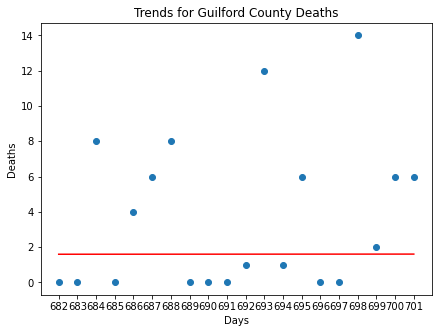

In [996]:
# plotting for best model i.e linear regression model
plt.figure(figsize=(7,5))
plt.xticks(X_test_gui)
plt.title('Trends for Guilford County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.scatter(X_test_gui,y_test_gui_d)
plt.plot(X_test_gui,lr_pred_test_gui_d, color='red')

## Trend Line for Guilford County cases

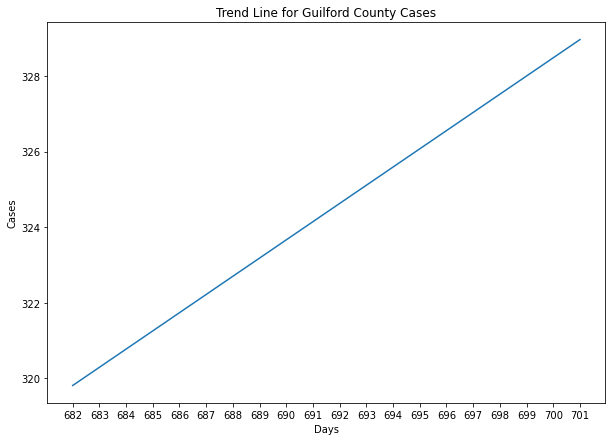

In [997]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_gui)
plt.title('Trend Line for Guilford County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_gui,lr_pred_test_gui_c)

### Confidence Intervals for guilford Cases

In [998]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [999]:
for i in lr_pred_test_gui_c:
    print("The confidence interval is [",get_prediction_interval(i,y_test_gui_c, lr_pred_test_gui_c)[0],
          ',',get_prediction_interval(i,y_test_gui_c, lr_pred_test_gui_c)[2],"]")

The confidence interval is [ -567.2747569037408 , 1206.8997892955522 ]
The confidence interval is [ -566.7931797701938 , 1207.3813664290992 ]
The confidence interval is [ -566.3116026366469 , 1207.8629435626463 ]
The confidence interval is [ -565.8300255030999 , 1208.344520696193 ]
The confidence interval is [ -565.3484483695529 , 1208.82609782974 ]
The confidence interval is [ -564.8668712360059 , 1209.3076749632871 ]
The confidence interval is [ -564.3852941024589 , 1209.789252096834 ]
The confidence interval is [ -563.903716968912 , 1210.270829230381 ]
The confidence interval is [ -563.422139835365 , 1210.752406363928 ]
The confidence interval is [ -562.940562701818 , 1211.233983497475 ]
The confidence interval is [ -562.458985568271 , 1211.715560631022 ]
The confidence interval is [ -561.9774084347241 , 1212.1971377645689 ]
The confidence interval is [ -561.4958313011771 , 1212.678714898116 ]
The confidence interval is [ -561.0142541676302 , 1213.1602920316627 ]
The confidence inte

In [1000]:
upper, lower = [], []
for i in range(len(X_test_gui)):
    lower.append(get_prediction_interval(i,y_test_gui_c, lr_pred_test_gui_c)[0])
    upper.append(get_prediction_interval(i,y_test_gui_c, lr_pred_test_gui_c)[2])

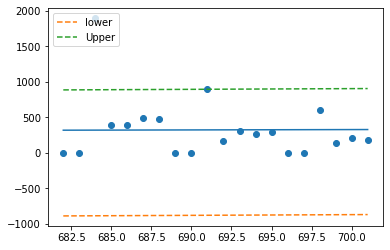

In [1001]:
plt.scatter(X_test_gui,y_test_gui_c)
plt.plot(X_test_gui,lr_pred_test_gui_c)
plt.plot(X_test_gui,lower,'--',label='lower')
plt.plot(X_test_gui,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Cases (forecast)

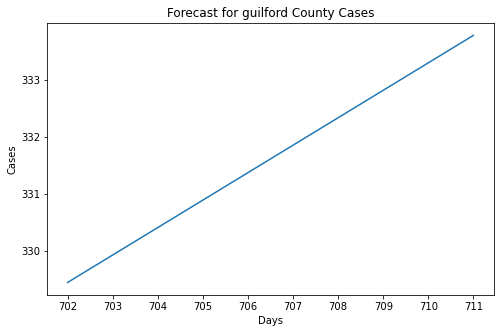

In [1002]:
future_days = np.arange(702,712)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for guilford County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(future_days,lr.predict(future_days.reshape(-1, 1)))  

## Trend Line for guilford County Deaths

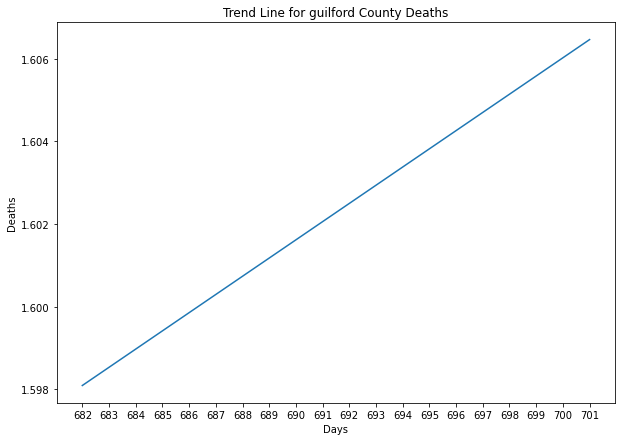

In [1003]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_gui)
plt.title('Trend Line for guilford County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(X_test_gui,lr_pred_test_gui_d)

### Confidence Intervals for guilford Deaths

In [1004]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [1005]:
for i in lr_pred_test_gui_d:
    print("The confidence interval is [",get_prediction_interval(i,y_test_gui_d, lr_pred_test_gui_d)[0],
          ',',get_prediction_interval(i,y_test_gui_d, lr_pred_test_gui_d)[2],"]")

The confidence interval is [ -8.18106428838935 , 11.377246373558219 ]
The confidence interval is [ -8.180623759754988 , 11.37768690219258 ]
The confidence interval is [ -8.180183231120628 , 11.378127430826941 ]
The confidence interval is [ -8.179742702486266 , 11.378567959461304 ]
The confidence interval is [ -8.179302173851905 , 11.379008488095664 ]
The confidence interval is [ -8.178861645217545 , 11.379449016730025 ]
The confidence interval is [ -8.178421116583182 , 11.379889545364387 ]
The confidence interval is [ -8.177980587948822 , 11.380330073998747 ]
The confidence interval is [ -8.17754005931446 , 11.38077060263311 ]
The confidence interval is [ -8.177099530680099 , 11.38121113126747 ]
The confidence interval is [ -8.176659002045739 , 11.38165165990183 ]
The confidence interval is [ -8.176218473411376 , 11.382092188536193 ]
The confidence interval is [ -8.175777944777016 , 11.382532717170553 ]
The confidence interval is [ -8.175337416142654 , 11.382973245804916 ]
The confiden

In [1006]:
upper, lower = [], []
for i in range(len(X_test_gui)):
    lower.append(get_prediction_interval(i,y_test_gui_d, lr_pred_test_gui_d)[0])
    upper.append(get_prediction_interval(i,y_test_gui_d, lr_pred_test_gui_d)[2])

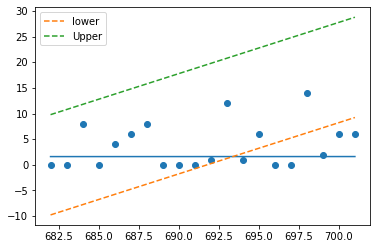

In [1007]:
plt.scatter(X_test_gui,y_test_gui_d)
plt.plot(X_test_gui,lr_pred_test_gui_d)
plt.plot(X_test_gui,lower,'--',label='lower')
plt.plot(X_test_gui,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Deaths (forecast)

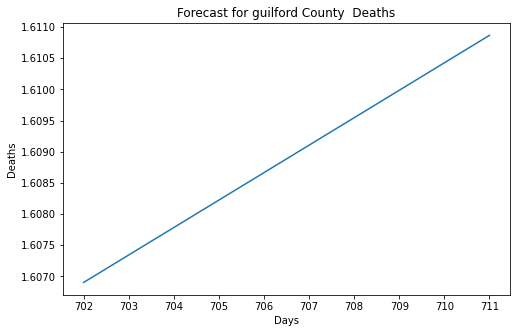

In [1008]:
future_days = np.arange(702,712)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for guilford County  Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(future_days,lr1.predict(future_days.reshape(-1, 1)))  

## Forsyth County Analysis

In [1009]:
for_cnty1 = for_cnty1[1:]
for_cnty1

,Date,Cases,Death,new_cases,new_deaths
1,2020-03-12,2,0,0.0,0.0
2,2020-03-13,2,0,0.0,0.0
3,2020-03-14,2,0,0.0,0.0
4,2020-03-15,2,0,0.0,0.0
5,2020-03-16,2,0,0.0,0.0
...,...,...,...,...,...
704,2022-02-13,89470,728,0.0,0.0
705,2022-02-14,89911,732,441.0,4.0
706,2022-02-15,89991,739,80.0,7.0
707,2022-02-16,90139,742,148.0,3.0



### Modelling for Forsyth County

In [1010]:
for_cnty1['Day_count'] = np.arange(1,len(for_cnty1)+1)
for_cnty1

,Date,Cases,Death,new_cases,new_deaths,Day_count
1,2020-03-12,2,0,0.0,0.0,1
2,2020-03-13,2,0,0.0,0.0,2
3,2020-03-14,2,0,0.0,0.0,3
4,2020-03-15,2,0,0.0,0.0,4
5,2020-03-16,2,0,0.0,0.0,5
...,...,...,...,...,...,...
704,2022-02-13,89470,728,0.0,0.0,704
705,2022-02-14,89911,732,441.0,4.0,705
706,2022-02-15,89991,739,80.0,7.0,706
707,2022-02-16,90139,742,148.0,3.0,707


In [1011]:
X_train_for = for_cnty1['Day_count'][:696]
y_train_for_c = for_cnty1['new_cases'][:696]
y_train_for_d = for_cnty1['new_deaths'][:696]
X_test_for = for_cnty1['Day_count'][696:]
y_test_for_c = for_cnty1['new_cases'][696:]
y_test_for_d = for_cnty1['new_deaths'][696:]

In [1012]:
X_train_for = np.array(X_train_for).reshape(-1,1)
X_test_for = np.array(X_test_for).reshape(-1,1)

## Linear Regression for new cases

In [1013]:
lr = LinearRegression()
lr.fit(X_train_for,y_train_for_c)

LinearRegression()

In [1014]:
lr_pred_test_for_c = lr.predict(X_test_for)
lr_pred_test_for_c

array([270.36194906, 270.77607164, 271.19019422, 271.6043168 ,
       272.01843938, 272.43256196, 272.84668454, 273.26080712,
       273.6749297 , 274.08905228, 274.50317486, 274.91729744])

### Calcluate error using RMSE for Linear Regression.

In [1015]:
# https://stackoverflow.com/a/18623635
rms_for_c = sqrt(mean_squared_error(y_test_for_c, lr_pred_test_for_c))
rms_for_c

227.3165595672881

## Polynomial Regression Model

### For New cases

In [1016]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [1017]:
# polynomial features with degree 2
pl_rg2_for_c = PolynomialRegression(2)
pl_rg2_for_c.fit(X_train_for, y_train_for_c)
py_test_pred2_for_c = pl_rg2_for_c.predict(X_test_for)

In [1018]:
py_test_pred2_for_c

array([383.84376   , 385.23477047, 386.62858006, 388.02518875,
       389.42459655, 390.82680345, 392.23180946, 393.63961457,
       395.05021879, 396.46362211, 397.87982454, 399.29882608])

In [1019]:
# polynomial features with degree 3 for new cases
pl_rg3_for_c = PolynomialRegression(3)
pl_rg3_for_c.fit(X_train_for, y_train_for_c)
py_test_pred3_for_c = pl_rg3_for_c.predict(X_test_for)

In [1020]:
py_test_pred3_for_c

array([606.8582352 , 612.08880623, 617.34968038, 622.64093635,
       627.96265282, 633.31490851, 638.69778209, 644.11135228,
       649.55569776, 655.03089722, 660.53702937, 666.0741729 ])

### RMSE for polynomial features of new cases

In [1021]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_for_c = sqrt(mean_squared_error(y_test_for_c, py_test_pred2_for_c))
poly_rmse2_for_c 

284.12680703452327

In [1022]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_c = sqrt(mean_squared_error(y_test_for_c, py_test_pred3_for_c))
poly_rmse3_c

480.1787251330869

## Linear Regression for new deaths

In [1023]:
lr1 = LinearRegression()
lr1.fit(X_train_for,y_train_for_d)

LinearRegression()

In [1024]:
lr_pred_test_for_d = lr1.predict(X_test_for)
lr_pred_test_for_d

array([1.55829819, 1.55987546, 1.56145272, 1.56302999, 1.56460726,
       1.56618452, 1.56776179, 1.56933906, 1.57091632, 1.57249359,
       1.57407086, 1.57564812])

### Calcluate error using RMSE for Linear Regression.

In [1025]:
# https://stackoverflow.com/a/18623635
rms_d = sqrt(mean_squared_error(y_test_for_d, lr_pred_test_for_d))
rms_d

3.5608365087534364

## Trend for Forsyth County Cases

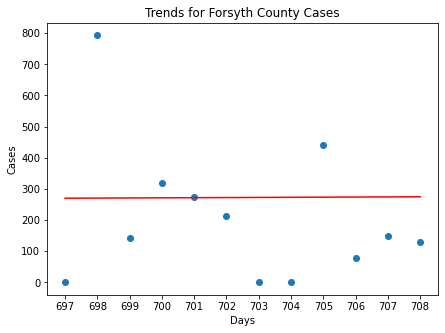

In [1026]:
# plotting for best model i.e linear regression model
plt.figure(figsize=(7,5))
plt.xticks(X_test_for)
plt.title('Trends for Forsyth County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_for,y_test_for_c)
plt.plot(X_test_for,lr_pred_test_for_c, color='red')

## Polynomial Regression Model

### For New deaths

In [1027]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [1028]:
# polynomial features with degree 2
pl_rg2_for_d = PolynomialRegression(2)
pl_rg2_for_d.fit(X_train_for, y_train_for_d)
py_test_pred2_for_d = pl_rg2_for_d.predict(X_test_for)

In [1029]:
py_test_pred2_for_d

array([1.39275943, 1.39291168, 1.39305986, 1.39320395, 1.39334395,
       1.39347988, 1.39361172, 1.39373947, 1.39386315, 1.39398274,
       1.39409825, 1.39420967])

In [1030]:
# polynomial features with degree 3
pl_rg3_for_d = PolynomialRegression(3)
pl_rg3_for_d.fit(X_train_for, y_train_for_d)
py_test_pred3_for_d = pl_rg3_for_d.predict(X_test_for)

In [1031]:
py_test_pred3_for_d

array([2.21959585, 2.23398345, 2.24846894, 2.26305262, 2.27773476,
       2.29251567, 2.30739564, 2.32237496, 2.33745391, 2.3526328 ,
       2.36791191, 2.38329153])

### RMSE for polynomial features of new deaths

In [1032]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_for_d = sqrt(mean_squared_error(y_test_for_d, py_test_pred2_for_d))
poly_rmse2_for_d

3.6494824184561447

In [1033]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_for_d = sqrt(mean_squared_error(y_test_for_d, py_test_pred3_for_d))
poly_rmse3_for_d

3.2653997898227876

## Trend for Forsyth County Deaths

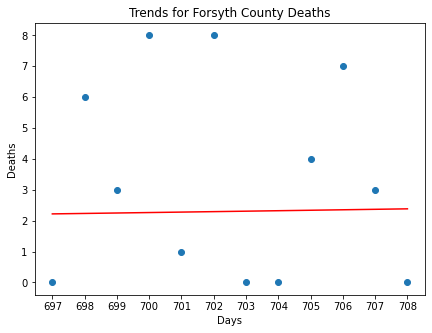

In [1034]:
# plotting for best model i.e linear regression model
plt.figure(figsize=(7,5))
plt.xticks(X_test_for)
plt.title('Trends for Forsyth County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.scatter(X_test_for,y_test_for_d)
plt.plot(X_test_for,py_test_pred3_for_d, color='red')

## Trend Line for Forsyth County cases

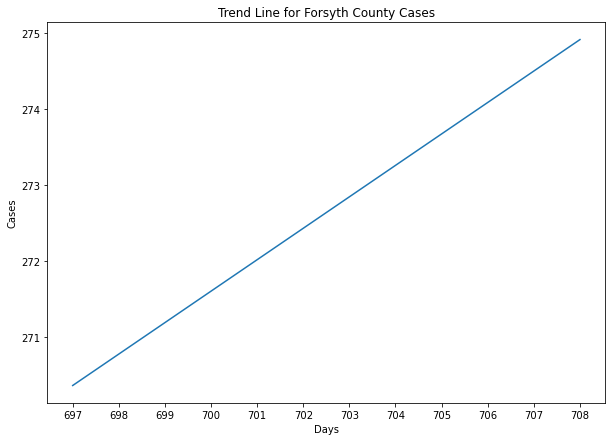

In [1035]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_for)
plt.title('Trend Line for Forsyth County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_for,lr_pred_test_for_c)

### Confidence Intervals for Forsyth Cases

In [1036]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [1037]:
for i in lr_pred_test_for_c:
    print("The confidence interval is [",get_prediction_interval(i,y_test_for_c, lr_pred_test_for_c)[0],
          ',',get_prediction_interval(i,y_test_for_c, lr_pred_test_for_c)[2],"]")

The confidence interval is [ -217.6941995158286 , 758.4180976387095 ]
The confidence interval is [ -217.28007693569543 , 758.8322202188426 ]
The confidence interval is [ -216.8659543555624 , 759.2463427989757 ]
The confidence interval is [ -216.45183177542935 , 759.6604653791087 ]
The confidence interval is [ -216.0377091952962 , 760.0745879592419 ]
The confidence interval is [ -215.62358661516316 , 760.4887105393749 ]
The confidence interval is [ -215.20946403503 , 760.902833119508 ]
The confidence interval is [ -214.79534145489697 , 761.3169556996411 ]
The confidence interval is [ -214.38121887476382 , 761.7310782797742 ]
The confidence interval is [ -213.96709629463078 , 762.1452008599073 ]
The confidence interval is [ -213.55297371449763 , 762.5593234400404 ]
The confidence interval is [ -213.1388511343646 , 762.9734460201735 ]


In [1038]:
upper, lower = [], []
for i in range(len(X_test_for)):
    lower.append(get_prediction_interval(i,y_test_for_c, lr_pred_test_for_c)[0])
    upper.append(get_prediction_interval(i,y_test_for_c, lr_pred_test_for_c)[2])

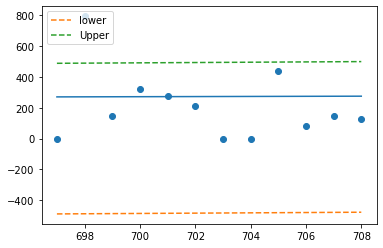

In [1039]:
plt.scatter(X_test_for,y_test_for_c)
plt.plot(X_test_for,lr_pred_test_for_c)
plt.plot(X_test_for,lower,'--',label='lower')
plt.plot(X_test_for,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Cases (forecast)

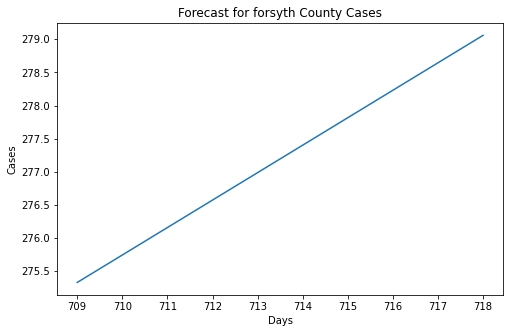

In [1040]:
future_days = np.arange(709,719)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for forsyth County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(future_days,lr.predict(future_days.reshape(-1, 1)))  

## Trend Line for Forsyth County Deaths

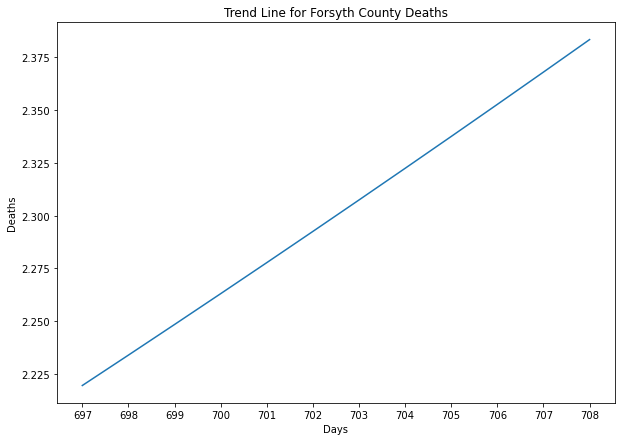

In [1041]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_for)
plt.title('Trend Line for Forsyth County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(X_test_for,py_test_pred3_for_d)

### Confidence Intervals for Forsyth Deaths

In [1042]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [1043]:
for i in lr_pred_test_for_d:
    print("The confidence interval is [",get_prediction_interval(i,y_test_for_d, py_test_pred3_for_d)[0],
          ',',get_prediction_interval(i,y_test_for_d, py_test_pred3_for_d)[2],"]")

The confidence interval is [ -5.452622827980423 , 8.56921920605038 ]
The confidence interval is [ -5.451045561124239 , 8.570796472906563 ]
The confidence interval is [ -5.449468294268057 , 8.572373739762746 ]
The confidence interval is [ -5.447891027411874 , 8.573951006618929 ]
The confidence interval is [ -5.44631376055569 , 8.575528273475111 ]
The confidence interval is [ -5.444736493699507 , 8.577105540331296 ]
The confidence interval is [ -5.443159226843324 , 8.578682807187478 ]
The confidence interval is [ -5.441581959987142 , 8.580260074043661 ]
The confidence interval is [ -5.440004693130958 , 8.581837340899845 ]
The confidence interval is [ -5.4384274262747745 , 8.583414607756028 ]
The confidence interval is [ -5.436850159418592 , 8.58499187461221 ]
The confidence interval is [ -5.435272892562409 , 8.586569141468393 ]


In [1044]:
upper, lower = [], []
for i in range(len(X_test_for)):
    lower.append(get_prediction_interval(i,y_test_for_d, py_test_pred3_for_d)[0])
    upper.append(get_prediction_interval(i,y_test_for_d, py_test_pred3_for_d)[2])

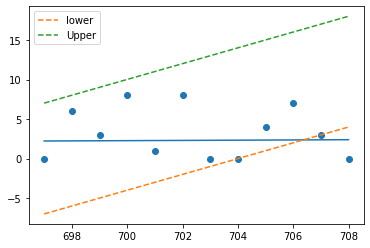

In [1045]:
plt.scatter(X_test_for,y_test_for_d)
plt.plot(X_test_for,py_test_pred3_for_d)
plt.plot(X_test_for,lower,'--',label='lower')
plt.plot(X_test_for,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Deaths (forecast)

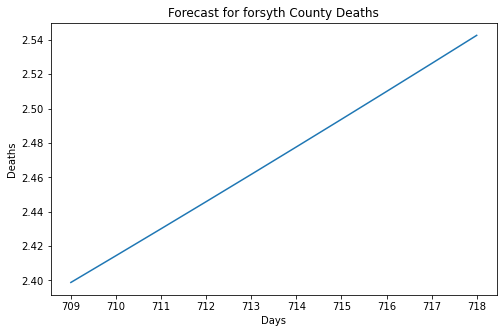

In [1046]:
future_days = np.arange(709,719)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for forsyth County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(future_days,pl_rg3_for_d.predict(future_days.reshape(-1, 1)))  

## Cumberland County Analysis

In [1047]:
cum_cnty1 = cum_cnty1[1:]
cum_cnty1

,Date,Cases,Death,new_cases,new_deaths
1,2020-03-22,2,0,0.0,0.0
2,2020-03-23,2,0,0.0,0.0
3,2020-03-24,2,0,0.0,0.0
4,2020-03-25,3,0,1.0,0.0
5,2020-03-26,7,0,4.0,0.0
...,...,...,...,...,...
694,2022-02-13,79529,524,0.0,0.0
695,2022-02-14,80109,525,580.0,1.0
696,2022-02-15,80250,526,141.0,1.0
697,2022-02-16,80416,528,166.0,2.0



### Modelling for Cumberland County

In [1048]:
cum_cnty1['Day_count'] = np.arange(1,len(cum_cnty1)+1)
cum_cnty1

,Date,Cases,Death,new_cases,new_deaths,Day_count
1,2020-03-22,2,0,0.0,0.0,1
2,2020-03-23,2,0,0.0,0.0,2
3,2020-03-24,2,0,0.0,0.0,3
4,2020-03-25,3,0,1.0,0.0,4
5,2020-03-26,7,0,4.0,0.0,5
...,...,...,...,...,...,...
694,2022-02-13,79529,524,0.0,0.0,694
695,2022-02-14,80109,525,580.0,1.0,695
696,2022-02-15,80250,526,141.0,1.0,696
697,2022-02-16,80416,528,166.0,2.0,697


In [1049]:
X_train_cum = cum_cnty1['Day_count'][:678]
y_train_cum_c = cum_cnty1['new_cases'][:678]
y_train_cum_d = cum_cnty1['new_deaths'][:678]
X_test_cum = cum_cnty1['Day_count'][678:]
y_test_cum_c = cum_cnty1['new_cases'][678:]
y_test_cum_d = cum_cnty1['new_deaths'][678:]

In [1050]:
X_train_cum = np.array(X_train_cum).reshape(-1,1)
X_test_cum = np.array(X_test_cum).reshape(-1,1)

## Wake County Analysis

## Linear Regression for new cases

In [1051]:
lr = LinearRegression()
lr.fit(X_train_cum,y_train_cum_c)

LinearRegression()

In [1052]:
lr_pred_test_cum_c = lr.predict(X_test_cum)
lr_pred_test_cum_c

array([235.93460216, 236.31249026, 236.69037836, 237.06826646,
       237.44615455, 237.82404265, 238.20193075, 238.57981885,
       238.95770695, 239.33559504, 239.71348314, 240.09137124,
       240.46925934, 240.84714743, 241.22503553, 241.60292363,
       241.98081173, 242.35869983, 242.73658792, 243.11447602])

### Calcluate error using RMSE for Linear Regression.

In [1053]:
# https://stackoverflow.com/a/18623635
rms_cum_c = sqrt(mean_squared_error(y_test_cum_c, lr_pred_test_cum_c))
rms_cum_c

518.726947160051

## Polynomial Regression Model

### For New cases

In [1054]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [1055]:
# polynomial features with degree 2
pl_rg2_cum_c = PolynomialRegression(2)
pl_rg2_cum_c.fit(X_train_cum, y_train_cum_c)
py_test_pred2_cum_c = pl_rg2_cum_c.predict(X_test_cum)

In [1056]:
py_test_pred2_cum_c

array([325.51012769, 326.67955209, 327.85130455, 329.02538505,
       330.2017936 , 331.3805302 , 332.56159484, 333.74498753,
       334.93070828, 336.11875707, 337.3091339 , 338.50183879,
       339.69687172, 340.8942327 , 342.09392173, 343.29593881,
       344.50028394, 345.70695711, 346.91595833, 348.1272876 ])

In [1057]:
# polynomial features with degree 3 for new cases
pl_rg3_cum_c = PolynomialRegression(3)
pl_rg3_cum_c.fit(X_train_cum, y_train_cum_c)
py_test_pred3_cum_c = pl_rg3_cum_c.predict(X_test_cum)

In [1058]:
py_test_pred3_cum_c

array([504.65506738, 508.99052901, 513.35159838, 517.73834385,
       522.15083379, 526.58913657, 531.05332056, 535.54345413,
       540.05960565, 544.60184348, 549.170236  , 553.76485158,
       558.38575858, 563.03302538, 567.70672034, 572.40691183,
       577.13366822, 581.88705788, 586.66714919, 591.4740105 ])

### RMSE for polynomial features of new cases

In [1059]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_cum_c = sqrt(mean_squared_error(y_test_cum_c, py_test_pred2_cum_c))
poly_rmse2_cum_c 

502.710107613063

In [1060]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_c = sqrt(mean_squared_error(y_test_cum_c, py_test_pred3_cum_c))
poly_rmse3_c

534.4759034334833

## Trend for Cumberland County Cases

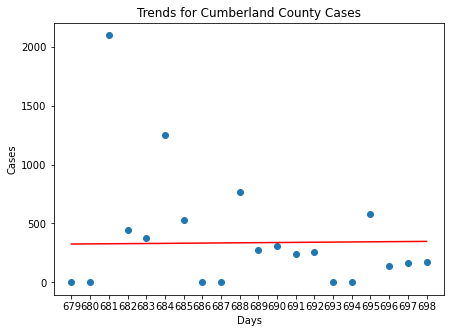

In [1061]:
# plotting for best model i.e polynomial regression model degree 2
plt.figure(figsize=(7,5))
plt.xticks(X_test_cum)
plt.title('Trends for Cumberland County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_cum,y_test_cum_c)
plt.plot(X_test_cum,py_test_pred2_cum_c, color='red')

## Linear Regression for new deaths

In [1062]:
lr1 = LinearRegression()
lr1.fit(X_train_cum,y_train_cum_d)

LinearRegression()

In [1063]:
lr_pred_test_cum_d = lr1.predict(X_test_cum)
lr_pred_test_cum_d

array([1.00086273, 1.00156907, 1.0022754 , 1.00298174, 1.00368807,
       1.00439441, 1.00510074, 1.00580708, 1.00651342, 1.00721975,
       1.00792609, 1.00863242, 1.00933876, 1.01004509, 1.01075143,
       1.01145776, 1.0121641 , 1.01287043, 1.01357677, 1.0142831 ])

### Calcluate error using RMSE for Linear Regression.

In [1064]:
# https://stackoverflow.com/a/18623635
rms_d = sqrt(mean_squared_error(y_test_cum_d, lr_pred_test_cum_d))
rms_d

3.461432286093311

## Polynomial Regression Model

### For New deaths

In [1065]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [1066]:
# polynomial features with degree 2
pl_rg2_cum_d = PolynomialRegression(2)
pl_rg2_cum_d.fit(X_train_cum, y_train_cum_d)
py_test_pred2_cum_d = pl_rg2_cum_d.predict(X_test_cum)

In [1067]:
py_test_pred2_cum_d

array([0.53533183, 0.53192449, 0.52850505, 0.52507351, 0.52162987,
       0.51817414, 0.5147063 , 0.51122637, 0.50773433, 0.5042302 ,
       0.50071397, 0.49718564, 0.49364521, 0.49009268, 0.48652805,
       0.48295133, 0.4793625 , 0.47576158, 0.47214855, 0.46852343])

In [1068]:
# polynomial features with degree 3
pl_rg3_cum_d = PolynomialRegression(3)
pl_rg3_cum_d.fit(X_train_cum, y_train_cum_d)
py_test_pred3_cum_d = pl_rg3_cum_d.predict(X_test_cum)

In [1069]:
py_test_pred3_cum_d

array([0.45272579, 0.44785855, 0.44296848, 0.43805554, 0.4331197 ,
       0.42816094, 0.42317921, 0.4181745 , 0.41314676, 0.40809597,
       0.40302209, 0.39792509, 0.39280495, 0.38766163, 0.38249509,
       0.37730531, 0.37209225, 0.36685589, 0.36159619, 0.35631312])


### RMSE for polynomial features of new deaths

In [1070]:
# https://stackoverflow.com/a/18623635
# RMSE for polynomial features with degree 2 of new cases
poly_rmse2_cum_d = sqrt(mean_squared_error(y_test_cum_d, py_test_pred2_cum_d))
poly_rmse2_cum_d

3.5649798060241378

In [1071]:
# RMSE for polynomial features with degree 3 of new cases
poly_rmse3_cum_d = sqrt(mean_squared_error(y_test_cum_d, py_test_pred3_cum_d))
poly_rmse3_cum_d

3.594625378329189

## Trend for Cumberland County Deaths

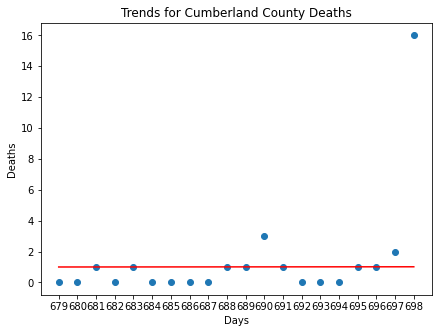

In [1072]:
# plotting for best model i.e linear model
plt.figure(figsize=(7,5))
plt.xticks(X_test_cum)
plt.title('Trends for Cumberland County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.scatter(X_test_cum,y_test_cum_d)
plt.plot(X_test_cum,lr_pred_test_cum_d, color='red')

### Member Task 2

## Trend Line for  Cumberland cases

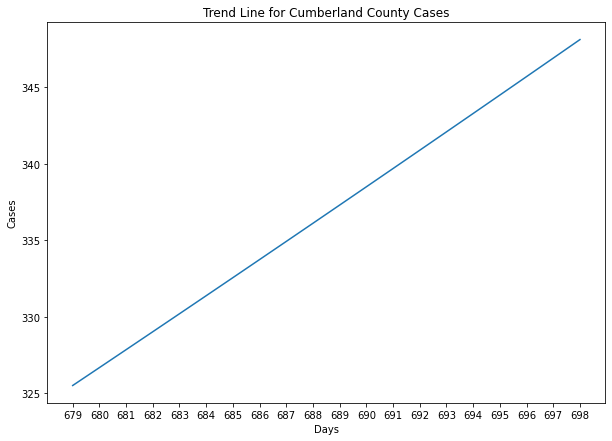

In [1073]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_cum)
plt.title('Trend Line for Cumberland County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_cum,py_test_pred2_cum_c)

### Confidence Intervals for Cumberland Cases

In [1074]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [1075]:
for i in lr_pred_test_cum_c:
    print("The confidence interval is [",get_prediction_interval(i,y_test_cum_c, py_test_pred2_cum_c)[0],
          ',',get_prediction_interval(i,y_test_cum_c, py_test_pred2_cum_c)[2],"]")

The confidence interval is [ -802.6561557974965 , 1274.5253601216232 ]
The confidence interval is [ -802.2782676995828 , 1274.9032482195369 ]
The confidence interval is [ -801.9003796016691 , 1275.2811363174505 ]
The confidence interval is [ -801.5224915037554 , 1275.6590244153642 ]
The confidence interval is [ -801.1446034058416 , 1276.036912513278 ]
The confidence interval is [ -800.7667153079279 , 1276.4148006111918 ]
The confidence interval is [ -800.3888272100141 , 1276.7926887091055 ]
The confidence interval is [ -800.0109391121005 , 1277.1705768070192 ]
The confidence interval is [ -799.6330510141868 , 1277.5484649049329 ]
The confidence interval is [ -799.2551629162731 , 1277.9263530028466 ]
The confidence interval is [ -798.8772748183593 , 1278.3042411007605 ]
The confidence interval is [ -798.4993867204455 , 1278.6821291986741 ]
The confidence interval is [ -798.1214986225318 , 1279.0600172965878 ]
The confidence interval is [ -797.7436105246181 , 1279.4379053945015 ]
The con

In [1076]:
upper, lower = [], []
for i in range(len(X_test_cum)):
    lower.append(get_prediction_interval(i,y_test_cum_c, py_test_pred2_cum_c)[0])
    upper.append(get_prediction_interval(i,y_test_cum_c, py_test_pred2_cum_c)[2])

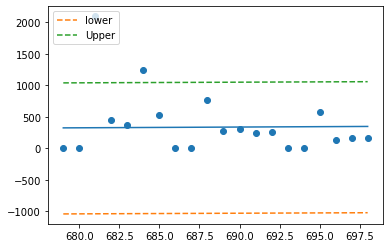

In [1077]:
plt.scatter(X_test_cum,y_test_cum_c)
plt.plot(X_test_cum,py_test_pred2_cum_c)
plt.plot(X_test_cum,lower,'--',label='lower')
plt.plot(X_test_cum,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Cases (forecast)

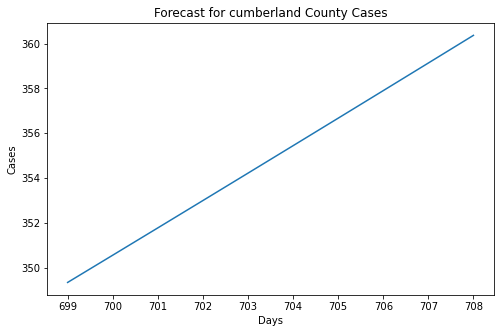

In [1078]:
future_days = np.arange(699,709)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('Forecast for cumberland County Cases')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(future_days,pl_rg2_cum_c.predict(future_days.reshape(-1, 1)))  

## Trend Line for Forsyth County Deaths

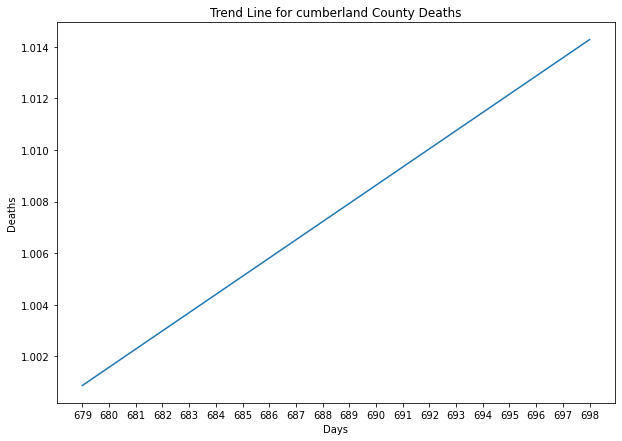

In [1079]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_cum)
plt.title('Trend Line for cumberland County Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(X_test_cum,lr_pred_test_cum_d)

### Confidence Intervals for Forsyth Cases

In [1080]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [1081]:
for i in lr_pred_test_cum_d:
    print("The confidence interval is [",get_prediction_interval(i,y_test_cum_d, lr_pred_test_cum_d)[0],
          ',',get_prediction_interval(i,y_test_cum_d, lr_pred_test_cum_d)[2],"]")

The confidence interval is [ -6.150399051443715 , 8.15212451908466 ]
The confidence interval is [ -6.149692716283427 , 8.152830854244948 ]
The confidence interval is [ -6.148986381123138 , 8.153537189405236 ]
The confidence interval is [ -6.14828004596285 , 8.154243524565524 ]
The confidence interval is [ -6.147573710802562 , 8.154949859725813 ]
The confidence interval is [ -6.146867375642274 , 8.155656194886102 ]
The confidence interval is [ -6.146161040481986 , 8.15636253004639 ]
The confidence interval is [ -6.145454705321698 , 8.157068865206679 ]
The confidence interval is [ -6.14474837016141 , 8.157775200366967 ]
The confidence interval is [ -6.144042035001122 , 8.158481535527255 ]
The confidence interval is [ -6.143335699840834 , 8.159187870687543 ]
The confidence interval is [ -6.142629364680546 , 8.15989420584783 ]
The confidence interval is [ -6.141923029520257 , 8.160600541008119 ]
The confidence interval is [ -6.141216694359969 , 8.161306876168407 ]
The confidence interval i

In [1082]:
upper, lower = [], []
for i in range(len(X_test_cum)):
    lower.append(get_prediction_interval(i,y_test_cum_d, lr_pred_test_cum_d)[0])
    upper.append(get_prediction_interval(i,y_test_cum_d, lr_pred_test_cum_d)[2])

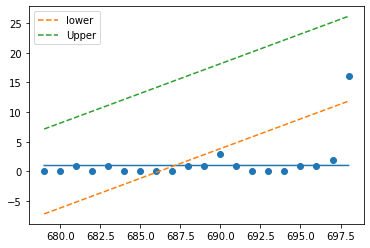

In [1083]:
plt.scatter(X_test_cum,y_test_cum_d)
plt.plot(X_test_cum,lr_pred_test_cum_d)
plt.plot(X_test_cum,lower,'--',label='lower')
plt.plot(X_test_cum,upper,'--',label='Upper')
plt.legend(loc='upper left')

## prediction path for Deaths (cumberland)

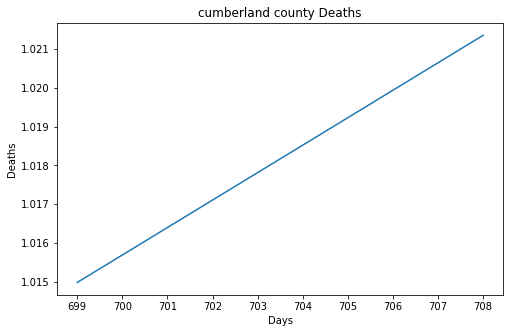

In [1084]:
future_days = np.arange(699,709)
plt.figure(figsize=(8,5))
plt.xticks(future_days)
plt.title('cumberland county Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.plot(future_days,lr1.predict(future_days.reshape(-1, 1)))  

### Hypothesis Testing

In [1085]:
pip install pingouin

In [1086]:
merged = pd.read_csv('../../../data/member/Praneeth/merged_file.csv')
merged

,Year,Month,State,Cases,Death,Employement
0,2020,January,Alaska,0,0,2123550
1,2020,January,Alabama,0,0,14323865
2,2020,January,Arkansas,0,0,8869770
3,2020,January,Arizona,6,0,22066206
4,2020,January,California,7594,0,130691423
...,...,...,...,...,...,...
913,2021,June,Vermont,729331,7677,2134851
914,2021,June,Washington,13303841,175075,24759978
915,2021,June,Wisconsin,20278835,247672,21138238
916,2021,June,West Virginia,4893264,85505,4756863


In [1087]:
nc_data = us_data[us_data['State']=='NC']
nm_data = us_data[us_data['State']=='NM']
oh_data = us_data[us_data['State']=='OH']

In [1088]:
nm_pop = nc_data['population'].unique().sum()
nm_pop = nm_data['population'].unique().sum()
oh_pop = oh_data['population'].unique().sum()

In [1089]:
nc_data = merged[merged['State']=='North Carolina']
nm_data = merged[merged['State']=='New Mexico']
oh_data = merged[merged['State']=='Ohio']

In [1090]:
nc_data['new_cases'] = nc_data['Cases'].diff()
nc_data['new_deaths'] = nc_data['Death'].diff()
nm_data['new_cases'] = nm_data['Cases'].diff()
nm_data['new_deaths'] = nm_data['Death'].diff()
oh_data['new_cases'] = oh_data['Cases'].diff()
oh_data['new_deaths'] = oh_data['Death'].diff()

In [1091]:
nm_data = nm_data[1:]
oh_data = oh_data[1:]
nc_data = nc_data[1:]

In [1092]:
nc_data['norm_new_cases'] = (nc_data['new_cases']/nm_pop)*100000
nc_data['norm_new_deaths'] = (nc_data['new_deaths']/nm_pop)*100000
nm_data['norm_new_cases'] = (nm_data['new_cases']/nm_pop)*100000
nm_data['norm_new_deaths'] = (nm_data['new_deaths']/nm_pop)*100000
oh_data['norm_new_cases'] = (oh_data['new_cases']/oh_pop)*100000
oh_data['norm_new_deaths'] = (oh_data['new_deaths']/oh_pop)*100000



In [1093]:
nc_data['norm_employment_number'] = (nc_data['Employement']/nm_pop)*100000
nm_data['norm_employment_number'] = (nm_data['Employement']/nm_pop)*100000
oh_data['norm_employment_number'] = (oh_data['Employement']/oh_pop)*100000

In [1094]:
nc_data.head()

,Year,Month,State,Cases,Death,Employement,new_cases,new_deaths,norm_new_cases,norm_new_deaths,norm_employment_number
78,2020,February,North Carolina,0,0,33104501,0.0,0.0,0.000000,0.000000,1.578789e+06
129,2020,March,North Carolina,8419,27,33004725,8419.0,27.0,401.511044,1.287659,1.574030e+06
180,2020,April,North Carolina,164854,4551,29088733,156435.0,4524.0,7460.551147,215.754361,1.387273e+06
231,2020,May,North Carolina,570697,19602,29891585,405843.0,15051.0,19355.083319,717.798161,1.425561e+06
282,2020,June,North Carolina,1373475,33831,30952530,802778.0,14229.0,38285.334665,678.596109,1.476159e+06


## Two-Sample T-test 

**We assume the null hypothesis as both the groups has the same variance. To prove this we use levene function from scipy.stats module to check the p_value.**

**The p-value is so less, so we reject the null hypothesis that two groups have same variance. So, we use  Welch’s t-test.**

In [1095]:
pip install pingouin

### NC Data T-test Two tail

In [1096]:
# https://www.marsja.se/how-to-perform-a-two-sample-t-test-with-python-3-different-methods/
import pingouin as pg

res = pg.ttest(nc_data['norm_new_cases'], nc_data['norm_new_deaths'], correction=True)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.857102,16.004044,two-sided,0.001394,"[37736.63, 129832.63]",1.322975,52.964,0.96238


In [1097]:
import pingouin as pg

res = pg.ttest(nc_data['norm_new_cases'], nc_data['norm_employment_number'], correction=True)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-56.259898,26.91517,two-sided,1.872994e-29,"[-1495464.1, -1390206.52]",19.296986,5.284e+29,1.0


In [1098]:
import pingouin as pg

res = pg.ttest(nc_data['norm_new_deaths'], nc_data['norm_employment_number'], correction=True)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-111.943729,16.010263,two-sided,1.333872e-24,"[-1555528.4, -1497711.48]",38.396382,8.553e+38,1.0


### One Tail test

### NC Data T-test one tail

In [1099]:
import pingouin as pg

res = pg.ttest(nc_data['norm_new_cases'], nc_data['norm_new_deaths'], correction=True, alternative = 'greater')
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.857102,16.004044,greater,0.000697,"[45860.83, inf]",1.322975,105.927,0.983368


In [1100]:
import pingouin as pg

res = pg.ttest(nc_data['norm_new_cases'], nc_data['norm_employment_number'], correction=True, alternative = 'greater')
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-56.259898,26.91517,greater,1.0,"[-1486522.55, inf]",19.296986,9.463e-31,0.0


In [1101]:
import pingouin as pg

res = pg.ttest(nc_data['norm_new_deaths'], nc_data['norm_employment_number'], correction=True, alternative = 'greater')
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-111.943729,16.010263,greater,1.0,"[-1550428.29, inf]",38.396382,5.846e-40,0.0


### NM Data T-test One tail

In [1102]:
import pingouin as pg

res = pg.ttest(nm_data['norm_new_cases'], nm_data['norm_new_deaths'], correction=True, alternative = 'greater')
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.851894,16.009498,greater,0.005765,"[6390.55, inf]",0.978192,12.488,0.874086


In [1103]:
import pingouin as pg

res = pg.ttest(nm_data['norm_new_cases'], nm_data['norm_employment_number'], correction=True, alternative = 'greater')
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-39.548813,21.135026,greater,1.0,"[-257303.23, inf]",13.565131,4.448e-26,0.0


In [1104]:
import pingouin as pg

res = pg.ttest(nm_data['norm_new_deaths'], nm_data['norm_employment_number'], correction=True, alternative = 'greater')
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-112.059714,16.057624,greater,1.0,"[-267152.78, inf]",38.436165,5.662e-40,0.0


### NM Data T-test Two tail

In [1105]:
import pingouin as pg

res = pg.ttest(nm_data['norm_new_cases'], nm_data['norm_new_deaths'], correction=True)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.851894,16.009498,two-sided,0.011531,"[4229.79, 28724.91]",0.978192,6.244,0.789714


In [1106]:
import pingouin as pg

res = pg.ttest(nm_data['norm_new_cases'], nm_data['norm_employment_number'], correction=True)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-39.548813,21.135026,two-sided,2.641754e-21,"[-259538.83, -233617.06]",13.565131,1.124e+25,1.0


In [1107]:
import pingouin as pg

res = pg.ttest(nm_data['norm_new_deaths'], nm_data['norm_employment_number'], correction=True)
display(res)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-112.059714,16.057624,two-sided,1.145598e-24,"[-268030.23, -258080.37]",38.436165,8.831e+38,1.0


### Conclusions

**1) Can we say the new cases can be directly related to new deaths ?** <br>
**From the analysis, the p value is less than 0.05 threshold, we can reject the null hypothesis.** 
<br>


**2) Can we say the rising or falling number of new covid cases are realted to employement numbers ?**<br>
**From the above analysis, the p value is less than 0.05 threshold, we can reject the null hypothesis.** 
<br>


**3) Can we say the rising or falling new deaths are related to employement numbers ?** <br>
**We can see that p value is less than 0.05 threshold, we can reject the null hypothesis.**